# ShaleHill Watershed

In [1]:
watershed = 'ShaleHills'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
path = os.getcwd().rsplit('/',1)[0] +'/RawData/'
path

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/26-ShaleHill/RawData/'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-10,50),
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1.Streamflow

In [4]:
data = pd.read_excel('http://www.czo.psu.edu/downloads/test/stream/Level_2_StreamFlow_2006-12_all.xlsx', 
              index_col='Collection_TimeStamp', header=0)
data.head(2)

Discharge_(cmd)
Collection_TimeStamp                
2006-01-01 00:00:00       131.58:q=E
2006-01-01 00:10:00       131.34:q=E

In [5]:
data.index.rename('Datetime',inplace=True)
data.rename(columns={data.columns[0]:'ShaleHill_Discharge'},inplace = True)
data['ShaleHill_Discharge'] = data['ShaleHill_Discharge'].apply(lambda x: x.split(':')[0])
data['ShaleHill_Discharge']  = pd.to_numeric(data['ShaleHill_Discharge'] )

In [6]:
prep = copy.deepcopy(data)
prep.index = pd.to_datetime(prep.index)
prep = threC(prep,'Discharge')
prep = prep.groupby(prep.index.date).mean()
prep.head(2)

ShaleHill_Discharge
2006-01-01            90.783542
2006-01-02            91.970833

ShaleHill_Discharge
2006-01-01             1.050735
2006-01-02             1.064477
2006-01-03             2.552341
2006-01-04             3.956431
2006-01-05             2.686823

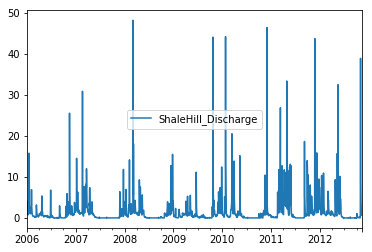

In [7]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 

ready_columns = pd.unique(prep.columns)
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

for i in np.arange(len(ready_columns)):
    tab = prep[ready_columns[i]]
    for j in np.arange(len(tab)):
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]/86.4 # from m3/d to L/s
            
Discharge = copy.deepcopy(df)
Discharge = threC(Discharge,'Discharge')
Discharge.plot()
Discharge.head()

### Hydrometeorology

### 2. Precipitation

In [8]:
data = pd.read_csv(path + 'Shale_prep_data.csv'
                      , header = 0,index_col = 'TmStamp',
                     parse_dates = True,
                   infer_datetime_format = True)
#data.drop(columns=['Device,'Unnamed: 8','Unnamed: 9'],index='TS',inplace = True)
data.head()

Total_Precip_mm Device Correlation Comment
TmStamp                                               
2006-01-01              0.7    OTT          NO     NaN
2006-01-02             12.1    OTT          NO     NaN
2006-01-03              1.9    OTT          NO     NaN
2006-01-04              1.0    OTT          NO     NaN
2006-01-05              2.0    OTT          NO     NaN

In [9]:
prep = copy.deepcopy(data[['Total_Precip_mm']])
prep.rename(columns={prep.columns[0]:'Precipitation'}, inplace = True)
prep = threC(prep,'Precipitation')
prep.head()

Precipitation
TmStamp                  
2006-01-01            0.7
2006-01-02           12.1
2006-01-03            1.9
2006-01-04            1.0
2006-01-05            2.0

ShaleHill_Precipitation
DateTime                           
2006-01-01                      0.7
2006-01-02                     12.1
2006-01-03                      1.9
2006-01-04                      1.0
2006-01-05                      2.0

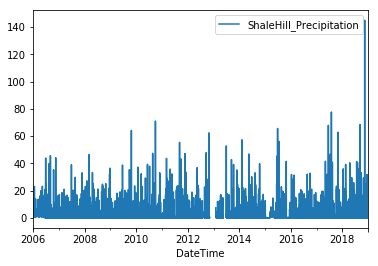

In [10]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 

ready_columns = pd.unique(prep.columns)
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

for i in np.arange(len(ready_columns)):
    tab = prep[ready_columns[i]]
    for j in np.arange(len(tab)):
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]
            
Precipitation = copy.deepcopy(df)
Precipitation.index.rename('DateTime',inplace =True)
Precipitation.rename(columns={Precipitation.columns[0]:'ShaleHill_Precipitation'},inplace =True)
Precipitation.plot()
Precipitation.head()

### 3. AirTemperature

In [11]:
data = pd.read_csv(path + 'SSHCZOHPAirTemp11.csv', header = 0,index_col = 'TmStamp',
                     parse_dates = True,infer_datetime_format = True)
display(data.head(2))
prep = copy.deepcopy(data)
prep.rename(columns={prep.columns[0]:'SSH11_AirTemperature'}, inplace = True)
prep = threC(prep,'AirTemperature')
prep = prep.groupby(prep.index.date).mean()
prep.index.rename('DateTime', inplace = True)
data1 = copy.deepcopy(prep)
data1.head(2)

120cm
TmStamp                   
2010-12-08 14:40:00  0.989
2010-12-08 14:50:00 -0.052

SSH11_AirTemperature
DateTime                        
2010-12-08             -3.276250
2010-12-09             -4.636125

In [12]:
data = pd.read_csv(path + 'SSHCZOHPAirTemp12.csv', header = 0,index_col = 'TmStamp',
                     parse_dates = True,infer_datetime_format = True)
display(data.head(2))
prep = copy.deepcopy(data)
prep.rename(columns={prep.columns[0]:'SSH12_AirTemperature'}, inplace = True)
prep = threC(prep,'AirTemperature')
prep = prep.groupby(prep.index.date).mean()
prep.index.rename('DateTime', inplace = True)
data2 = copy.deepcopy(prep)
data2.head(2)

120cm
TmStamp                   
2010-12-08 15:50:00  0.031
2010-12-08 16:00:00 -1.096

SSH12_AirTemperature
DateTime                        
2010-12-08             -4.467918
2010-12-09             -5.843417

In [13]:
data = pd.read_csv(path + 'SSHCZOHPAirTemp51.csv', header = 0,index_col = 'TmStamp',
                     parse_dates = True,infer_datetime_format = True)
display(data.head(2))
prep = copy.deepcopy(data)
prep.rename(columns={prep.columns[0]:'SSH51_AirTemperature'}, inplace = True)
prep = threC(prep,'AirTemperature')
prep = prep.groupby(prep.index.date).mean()
prep.index.rename('DateTime', inplace = True)
data3 = copy.deepcopy(prep)
data3.head(2)

95cm
TmStamp                  
2007-01-01 00:08:00   0.0
2007-01-01 00:18:00   0.0

SSH51_AirTemperature
DateTime                        
2007-01-01                   0.0
2007-01-02                   0.0

In [14]:
data = pd.read_csv(path + 'SSHCZOHPAirTemp60.csv', header = 0,index_col = 'TmStamp',
                     parse_dates = True,infer_datetime_format = True)
display(data.head(2))
prep = copy.deepcopy(data)
prep.rename(columns={prep.columns[0]:'SSH60_AirTemperature'}, inplace = True)
prep = threC(prep,'AirTemperature')
prep = prep.groupby(prep.index.date).mean()
prep.index.rename('DateTime', inplace = True)
data4 = copy.deepcopy(prep)
data4.head(2)

120cm
TmStamp                   
2007-01-01 00:06:00    0.0
2007-01-01 00:16:00    0.0

SSH60_AirTemperature
DateTime                        
2007-01-01                   0.0
2007-01-02                   0.0

In [15]:
df_lst=[data1,data2,data3,data4]
for df in df_lst:
    df.index=pd.to_datetime(df.index)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

The final table is:


SSH11_AirTemperature SSH12_AirTemperature SSH51_AirTemperature  \
2007-01-01                  NaN                  NaN                    0   
2007-01-02                  NaN                  NaN                    0   

           SSH60_AirTemperature  
2007-01-01                    0  
2007-01-02                    0

SSH11_AirTemperature SSH12_AirTemperature SSH51_AirTemperature  \
2014-08-16                  NaN                  NaN              16.6816   
2014-08-17                  NaN                  NaN              18.1234   

           SSH60_AirTemperature  
2014-08-16              16.2808  
2014-08-17              18.2708

SSH11_AirTemperature  SSH12_AirTemperature  SSH51_AirTemperature  \
2007-01-01                   NaN                   NaN                   0.0   
2007-01-02                   NaN                   NaN                   0.0   
2007-01-03                   NaN                   NaN                   0.0   
2007-01-04                   NaN                   NaN                   0.0   
2007-01-05                   NaN                   NaN                   0.0   

            SSH60_AirTemperature  
2007-01-01                   0.0  
2007-01-02                   0.0  
2007-01-03                   0.0  
2007-01-04                   0.0  
2007-01-05                   0.0

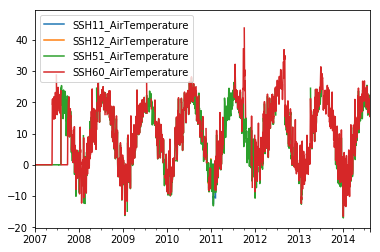

In [16]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 

ready_columns = pd.unique(prep.columns)
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

for i in np.arange(len(ready_columns)):
    tab = prep[ready_columns[i]]
    for j in np.arange(len(tab)):
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]
            
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()
AirTemperature.head()

### 4. SolarRadiation

In [17]:
data = pd.read_excel(path + 'CZO_FluxTowerMeteo_2009-13_all.xlsx', 
                    header = 0,skiprows = [0,2,3],index_col = 'TIMESTAMP',
                     parse_dates = True,infer_datetime_format = True)
data.index = pd.to_datetime(data.index)
prep = threC(prep,'SolarRadiation')
data = data.groupby(data.index.date).mean()
data.head()

RECORD  h2o_hmp_mean  LWS_current  T_hmp_mean  T_hmp_current  \
2009-04-01    62.5      6.424833   475.950000    6.339246       6.340381   
2009-04-02   197.5      7.073014   388.767361   11.168903      11.179910   
2009-04-03   341.5      8.666410   433.888889   11.078354      11.055771   
2009-04-04   485.5      3.917125   264.161806    5.712861       5.699181   
2009-04-05   629.5      3.155951   260.265278   10.672854      10.695465   

            RH_hmp_current  net_radiation_mean  
2009-04-01       86.678492           -0.770698  
2009-04-02       72.419167          132.690181  
2009-04-03       84.776806           -9.211049  
2009-04-04       55.321458           94.368201  
2009-04-05       35.625000          128.025514

SHFluxTower_SolarRadiation


SHFluxTower_SolarRadiation
2009-04-01                   -0.770698
2009-04-02                  132.690181
2009-04-03                   -9.211049
2009-04-04                   94.368201
2009-04-05                  128.025514

<Figure size 720x288 with 0 Axes>

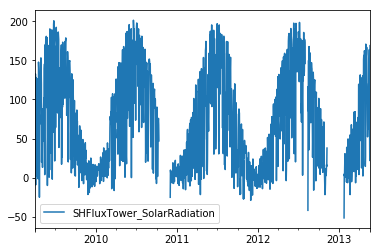

In [18]:
prep = copy.deepcopy(data[['net_radiation_mean']])
prep.columns = ['SHFluxTower_SolarRadiation']

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()
SolarRadiation.head()

### 4. RelativeHumidity

SHFluxTower_RelativeHumidity


SHFluxTower_RelativeHumidity
2009-04-01                     86.678492
2009-04-02                     72.419167
2009-04-03                     84.776806
2009-04-04                     55.321458
2009-04-05                     35.625000

<Figure size 720x288 with 0 Axes>

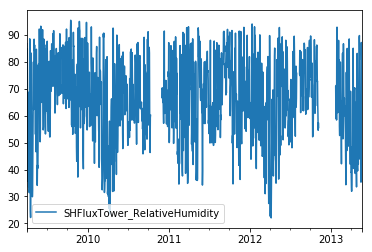

In [19]:
prep = copy.deepcopy(data[['RH_hmp_current']])
prep.columns = ['SHFluxTower_RelativeHumidity']
prep = threC(prep,'RelativeHumidity')

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head()

### 5. WindDirection
### None

### 6. Wind Speed
### None

### 7. SWE
### None

### 8.SnowDepth

In [20]:
data1 = pd.read_csv(path + 'ShaleHills_SnowDepth.csv', 
                    header = 0,index_col = 'Datetime',
                     parse_dates = True,infer_datetime_format = True)
data1.index = pd.to_datetime(data1.index)
data1 = data1.groupby(data1.index.date).mean()
data1.head()

RecNum  Snow_Depth_Avg        TCDT     Quality
2018-11-16    95.5        3.056144  161.487379  189.951389
2018-11-17   239.5       16.208536  148.504049  193.701389
2018-11-18   383.5       11.140111  153.578884  182.423611
2018-11-19   527.5        7.749695  156.950969  186.631944
2018-11-20   671.5        5.799427  158.906262  187.437500

SSHCZO_SnowDepth


SSHCZO_SnowDepth
2018-11-16          3.056144
2018-11-17         16.208536
2018-11-18         11.140111
2018-11-19          7.749695
2018-11-20          5.799427

<Figure size 720x288 with 0 Axes>

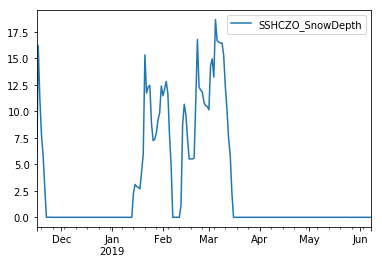

In [21]:
prep = copy.deepcopy(data1[['Snow_Depth_Avg']])
prep.columns = ['SSHCZO_SnowDepth']
prep = threC(prep,'SnowDepth')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SnowDepth = copy.deepcopy(df)
SnowDepth.dropna().plot()
SnowDepth.head()

### 9. SnowMelt
### None

### 10. VaporPressure

### 11. Evapotranspirartion

### 11. SoilMoisture

In [22]:
siteList = ['03','06','08','11','12','15a','15b','15c','51','53','55a','55b','60','61','74','A4']

In [23]:
for i in siteList:
    print(i)
    data = pd.read_csv(path + 'SSHCZOHPSoilMoist'+i+'.csv', 
                   header = 0,index_col = 'TmStamp',
                     parse_dates = True, 
                   infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    data.columns = ['SSH'+ i+'_SoilMoisture_'+k for k in data.columns]
    data = threC(data,'SoilMoisture')
    data = data.groupby(data.index.date).mean()
    if i ==siteList[0]:
        prep = data
    else:
        prep = pd.concat([prep,data], axis=1,sort = True)
    display(prep.head(2))

03


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2010-04-14                 0.286309                 0.265036   
2010-04-15                 0.285320                 0.265249   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2010-04-14                 0.181510                 0.181801   
2010-04-15                 0.182893                 0.182053   

            SSH03_SoilMoisture_50cm  
2010-04-14                 0.151203  
2010-04-15                 0.153227

06


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2010-04-14                 0.286309                 0.265036   
2010-04-15                 0.285320                 0.265249   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2010-04-14                 0.181510                 0.181801   
2010-04-15                 0.182893                 0.182053   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2010-04-14                 0.151203                      NaN   
2010-04-15                 0.153227                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2010-04-14                      NaN                      NaN   
2010-04-15                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  
2010-04-14                      NaN                      NaN  
2010-04-15                      NaN                      NaN

08


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH08_SoilMoisture_10cm  SSH08_SoilMoisture_20cm  \
2010-04-08                 0.245941                 0.157709   
2010-04-09                 0.245085                 0.159325   

            SSH08_SoilMoisture_30cm  SSH08_SoilMoisture_40cm  \
2010-04-08                 0.210019                      NaN   
2010-04-09                 0.211274                      NaN   

            SSH08_SoilMoisture_50cm  
2010-04-08                 0.200663  
2010-04-09                 0.208002

11


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2010-04-08                      NaN                      NaN  ...   
2010-04-09                      NaN                      NaN  ...   

            SSH08_SoilMoisture_30cm  SSH08_SoilMoisture_40cm  \
2010-04-08                 0.210019                      NaN   
2010-04-09                 0.211274                      NaN   

            SSH08_SoilMoisture_50cm  SSH11_SoilMoisture_11cm  \
2010-04-08                 0.200663                      NaN   
2010-04-09                 0.208002                      NaN   

            SSH11_SoilMoisture_36cm  SSH11_SoilMoisture_66cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH11_SoilMoisture_11cm_a  SSH11_SoilMoisture_24cm  \
2010-04-08                        NaN                      NaN   
2010-04-09                        NaN                      NaN   

            SSH11_SoilMoisture_36cm_a  SSH11_SoilMoisture_51cm  
2010-04-08                        NaN                      NaN  
2010-04-09                        NaN                      NaN  

[2 rows x 22 columns]

12


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2010-04-08                      NaN                      NaN  ...   
2010-04-09                      NaN                      NaN  ...   

            SSH11_SoilMoisture_24cm  SSH11_SoilMoisture_36cm_a  \
2010-04-08                      NaN                        NaN   
2010-04-09                      NaN                        NaN   

            SSH11_SoilMoisture_51cm  SSH12_SoilMoisture_10cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH12_SoilMoisture_48cm  SSH12_SoilMoisture_81cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH12_SoilMoisture_11cm  SSH12_SoilMoisture_27cm  \
2010-04-08                      NaN                      NaN   
2010-04-09                      NaN                      NaN   

            SSH12_SoilMoisture_48cm_a  SSH12_SoilMoisture_64cm  
2010-04-08                        NaN                      NaN  
2010-04-09                        NaN                      NaN  

[2 rows x 29 columns]

15a


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH12_SoilMoisture_48cm_a  SSH12_SoilMoisture_64cm  \
2007-01-01                        NaN                      NaN   
2007-01-02                        NaN                      NaN   

            SSH15a_SoilMoisture_13cm  SSH15a_SoilMoisture_20cm  \
2007-01-01                 38.106111                 34.633125   
2007-01-02                 38.297569                 34.811319   

            SSH15a_SoilMoisture_41cm  SSH15a_SoilMoisture_52cm  \
2007-01-01                       NaN                 35.844791   
2007-01-02                       NaN                 35.989306   

            SSH15a_SoilMoisture_73cm  SSH15a_SoilMoisture_85cm  \
2007-01-01                 32.467848                 32.384861   
2007-01-02                 32.543056                 32.469931   

            SSH15a_SoilMoisture_91cm  SSH15a_SoilMoisture_109cm  
2007-01-01                 37.082083                  33.322571  
2007-01-02                 37.103333                  33.369791  

[2 rows x 37 columns]

15b


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH15a_SoilMoisture_52cm  SSH15a_SoilMoisture_73cm  \
2007-01-01                 35.844791                 32.467848   
2007-01-02                 35.989306                 32.543056   

            SSH15a_SoilMoisture_85cm  SSH15a_SoilMoisture_91cm  \
2007-01-01                 32.384861                 37.082083   
2007-01-02                 32.469931                 37.103333   

            SSH15a_SoilMoisture_109cm  SSH15b_SoilMoisture_5cm  \
2007-01-01                  33.322571                      NaN   
2007-01-02                  33.369791                      NaN   

            SSH15b_SoilMoisture_13cm  SSH15b_SoilMoisture_20cm  \
2007-01-01                       NaN                       NaN   
2007-01-02                       NaN                       NaN   

            SSH15b_SoilMoisture_41cm  SSH15b_SoilMoisture_41cm_a  
2007-01-01                       NaN                         NaN  
2007-01-02                       NaN                         NaN  

[2 rows x 42 columns]

15c


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH15a_SoilMoisture_91cm  SSH15a_SoilMoisture_109cm  \
2007-01-01                 37.082083                  33.322571   
2007-01-02                 37.103333                  33.369791   

            SSH15b_SoilMoisture_5cm  SSH15b_SoilMoisture_13cm  \
2007-01-01                      NaN                       NaN   
2007-01-02                      NaN                       NaN   

            SSH15b_SoilMoisture_20cm  SSH15b_SoilMoisture_41cm  \
2007-01-01                       NaN                       NaN   
2007-01-02                       NaN                       NaN   

            SSH15b_SoilMoisture_41cm_a  SSH15c_SoilMoisture_52cm  \
2007-01-01                         NaN                       NaN   
2007-01-02                         NaN                       NaN   

            SSH15c_SoilMoisture_73cm  SSH15c_SoilMoisture_73cm_a  
2007-01-01                       NaN                         NaN  
2007-01-02                       NaN                         NaN  

[2 rows x 45 columns]

51


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH51_SoilMoisture_12cm  SSH51_SoilMoisture_18cm_a  \
2007-01-01                24.123916                  22.332307   
2007-01-02                23.816459                  22.100764   

            SSH51_SoilMoisture_25cm  SSH51_SoilMoisture_40cm_a  \
2007-01-01                21.715105                  22.182517   
2007-01-02                21.626250                  22.248750   

            SSH51_SoilMoisture_71cm  SSH51_SoilMoisture_98cm  \
2007-01-01                14.705734                17.042308   
2007-01-02                15.306736                17.358889   

            SSH51_SoilMoisture_123cm  SSH51_SoilMoisture_162cm  \
2007-01-01                 18.958951                 23.659441   
2007-01-02                 18.878403                 23.632917   

            SSH51_SoilMoisture_20cm  SSH51_SoilMoisture_20cm_a  
2007-01-01                 7.868531                        NaN  
2007-01-02                 7.750625                        NaN  

[2 rows x 62 columns]

53


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH53_SoilMoisture_10cm_a  SSH53_SoilMoisture_22cm  \
2007-01-01                  27.545000                26.350694   
2007-01-02                  26.909028                25.834861   

            SSH53_SoilMoisture_44cm  SSH53_SoilMoisture_73cm  \
2007-01-01                23.212431                20.066667   
2007-01-02                23.230833                20.427222   

            SSH53_SoilMoisture_123cm  SSH53_SoilMoisture_5cm_a  \
2007-01-01                 20.622292                 23.825070   
2007-01-02                 20.748958                 23.181667   

            SSH53_SoilMoisture_10cm_b  SSH53_SoilMoisture_40cm_a  \
2007-01-01                  22.438056                  22.107083   
2007-01-02                  21.712014                  21.995764   

            SSH53_SoilMoisture_88cm  SSH53_SoilMoisture_103cm  
2007-01-01                18.282084                 13.870417  
2007-01-02                18.760417                 14.720069  

[2 rows x 77 columns]

55a


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH55a_SoilMoisture_8cm  SSH55a_SoilMoisture_14cm  \
2007-01-01                      NaN                 20.021818   
2007-01-02                      NaN                 19.526389   

            SSH55a_SoilMoisture_41cm  SSH55a_SoilMoisture_86cm  \
2007-01-01                 21.228112                 23.663427   
2007-01-02                 21.219028                 24.374722   

            SSH55a_SoilMoisture_90cm  SSH55a_SoilMoisture_111cm  \
2007-01-01                 27.654405                  20.461958   
2007-01-02                 28.001806                  20.810417   

            SSH55a_SoilMoisture_5cm  SSH55a_SoilMoisture_7cm  \
2007-01-01                25.581189                24.435594   
2007-01-02                24.004514                23.099514   

            SSH55a_SoilMoisture_84cm  SSH55a_SoilMoisture_141cm  
2007-01-01                 26.338391                  17.201748  
2007-01-02                 26.577083                  17.549236  

[2 rows x 87 columns]

55b


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH55a_SoilMoisture_111cm  SSH55a_SoilMoisture_5cm  \
2007-01-01                  20.461958                25.581189   
2007-01-02                  20.810417                24.004514   

            SSH55a_SoilMoisture_7cm  SSH55a_SoilMoisture_84cm  \
2007-01-01                24.435594                 26.338391   
2007-01-02                23.099514                 26.577083   

            SSH55a_SoilMoisture_141cm  SSH55b_SoilMoisture_5cm  \
2007-01-01                  17.201748                      NaN   
2007-01-02                  17.549236                      NaN   

            SSH55b_SoilMoisture_8cm  SSH55b_SoilMoisture_14cm  \
2007-01-01                      NaN                       NaN   
2007-01-02                      NaN                       NaN   

            SSH55b_SoilMoisture_14cm_a  SSH55b_SoilMoisture_30cm  
2007-01-01                         NaN                       NaN  
2007-01-02                         NaN                       NaN  

[2 rows x 92 columns]

60


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH60_SoilMoisture_5cm  SSH60_SoilMoisture_8cm  \
2007-01-01               26.171458               23.374584   
2007-01-02               24.586180               22.558472   

            SSH60_SoilMoisture_21cm  SSH60_SoilMoisture_31cm  \
2007-01-01                29.673056                24.189305   
2007-01-02                29.028194                23.526528   

            SSH60_SoilMoisture_39cm  SSH60_SoilMoisture_5cm_a  \
2007-01-01                20.343611                 29.653542   
2007-01-02                20.072500                 27.901250   

            SSH60_SoilMoisture_8cm_a  SSH60_SoilMoisture_15cm  \
2007-01-01                 29.110764                23.343542   
2007-01-02                 27.516111                21.956181   

            SSH60_SoilMoisture_28cm  SSH60_SoilMoisture_38cm  
2007-01-01                18.971667                15.378611  
2007-01-02                18.051875                14.739653  

[2 rows x 102 columns]

61


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH60_SoilMoisture_15cm  SSH60_SoilMoisture_28cm  \
2007-01-01                23.343542                18.971667   
2007-01-02                21.956181                18.051875   

            SSH60_SoilMoisture_38cm  SSH61_SoilMoisture_13cm  \
2007-01-01                15.378611                22.204375   
2007-01-02                14.739653                21.325417   

            SSH61_SoilMoisture_20cm  SSH61_SoilMoisture_35cm  \
2007-01-01                21.021736                24.116528   
2007-01-02                20.408472                23.818611   

            SSH61_SoilMoisture_66cm  SSH61_SoilMoisture_86cm  \
2007-01-01                28.801944                27.688195   
2007-01-02                29.046875                27.843195   

            SSH61_SoilMoisture_95cm  SSH61_SoilMoisture_129cm  
2007-01-01                25.076389                 28.616597  
2007-01-02                25.323195                 30.178611  

[2 rows x 109 columns]

74


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH61_SoilMoisture_35cm  SSH61_SoilMoisture_66cm  \
2007-01-01                24.116528                28.801944   
2007-01-02                23.818611                29.046875   

            SSH61_SoilMoisture_86cm  SSH61_SoilMoisture_95cm  \
2007-01-01                27.688195                25.076389   
2007-01-02                27.843195                25.323195   

            SSH61_SoilMoisture_129cm  SSH74_SoilMoisture_5cm  \
2007-01-01                 28.616597               13.717431   
2007-01-02                 30.178611               12.448333   

            SSH74_SoilMoisture_8cm  SSH74_SoilMoisture_10cm  \
2007-01-01               18.041250                14.214722   
2007-01-02               17.419028                13.090486   

            SSH74_SoilMoisture_17cm  SSH74_SoilMoisture_37cm  
2007-01-01                20.781181                22.309583  
2007-01-02                20.297152                22.085347  

[2 rows x 114 columns]

A4


SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   

            SSH61_SoilMoisture_95cm  SSH61_SoilMoisture_129cm  \
2007-01-01                25.076389                 28.616597   
2007-01-02                25.323195                 30.178611   

            SSH74_SoilMoisture_5cm  SSH74_SoilMoisture_8cm  \
2007-01-01               13.717431               18.041250   
2007-01-02               12.448333               17.419028   

            SSH74_SoilMoisture_10cm  SSH74_SoilMoisture_17cm  \
2007-01-01                14.214722                20.781181   
2007-01-02                13.090486                20.297152   

            SSH74_SoilMoisture_37cm  SSHA4_SoilMoisture_5cm  \
2007-01-01                22.309583                     NaN   
2007-01-02                22.085347                     NaN   

            SSHA4_SoilMoisture_20cm  SSHA4_SoilMoisture_36cm  
2007-01-01                      NaN                      NaN  
2007-01-02                      NaN                      NaN  

[2 rows x 117 columns]

SSH03_SoilMoisture_10cm
SSH03_SoilMoisture_20cm
SSH03_SoilMoisture_30cm
SSH03_SoilMoisture_40cm
SSH03_SoilMoisture_50cm
SSH06_SoilMoisture_60cm
SSH06_SoilMoisture_40cm
SSH06_SoilMoisture_30cm
SSH06_SoilMoisture_20cm
SSH06_SoilMoisture_10cm
SSH08_SoilMoisture_10cm
SSH08_SoilMoisture_20cm
SSH08_SoilMoisture_30cm
SSH08_SoilMoisture_40cm
SSH08_SoilMoisture_50cm
SSH11_SoilMoisture_11cm
SSH11_SoilMoisture_36cm
SSH11_SoilMoisture_66cm
SSH11_SoilMoisture_11cm_a
SSH11_SoilMoisture_24cm
SSH11_SoilMoisture_36cm_a
SSH11_SoilMoisture_51cm
SSH12_SoilMoisture_10cm
SSH12_SoilMoisture_48cm
SSH12_SoilMoisture_81cm
SSH12_SoilMoisture_11cm
SSH12_SoilMoisture_27cm
SSH12_SoilMoisture_48cm_a
SSH12_SoilMoisture_64cm
SSH15a_SoilMoisture_13cm
SSH15a_SoilMoisture_20cm
SSH15a_SoilMoisture_41cm
SSH15a_SoilMoisture_52cm
SSH15a_SoilMoisture_73cm
SSH15a_SoilMoisture_85cm
SSH15a_SoilMoisture_91cm
SSH15a_SoilMoisture_109cm
SSH15b_SoilMoisture_5cm
SSH15b_SoilMoisture_13cm
SSH15b_SoilMoisture_20cm
SSH15b_SoilMoisture_41c

SSH03_SoilMoisture_10cm  SSH03_SoilMoisture_20cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   
2007-01-03                      NaN                      NaN   
2007-01-04                      NaN                      NaN   
2007-01-05                      NaN                      NaN   

            SSH03_SoilMoisture_30cm  SSH03_SoilMoisture_40cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   
2007-01-03                      NaN                      NaN   
2007-01-04                      NaN                      NaN   
2007-01-05                      NaN                      NaN   

            SSH03_SoilMoisture_50cm  SSH06_SoilMoisture_60cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   
2007-01-03                      NaN                      NaN   
2007-01-04                      NaN                      NaN   
2007-01-05                      NaN                      NaN   

            SSH06_SoilMoisture_40cm  SSH06_SoilMoisture_30cm  \
2007-01-01                      NaN                      NaN   
2007-01-02                      NaN                      NaN   
2007-01-03                      NaN                      NaN   
2007-01-04                      NaN                      NaN   
2007-01-05                      NaN                      NaN   

            SSH06_SoilMoisture_20cm  SSH06_SoilMoisture_10cm  ...  \
2007-01-01                      NaN                      NaN  ...   
2007-01-02                      NaN                      NaN  ...   
2007-01-03                      NaN                      NaN  ...   
2007-01-04                      NaN                      NaN  ...   
2007-01-05                      NaN                      NaN  ...   

            SSH61_SoilMoisture_95cm  SSH61_SoilMoisture_129cm  \
2007-01-01                25.076389                 28.616597   
2007-01-02                25.323195                 30.178611   
2007-01-03                25.248611                 30.930208   
2007-01-04                25.139930                 30.925764   
2007-01-05                25.065417                 30.887222   

            SSH74_SoilMoisture_5cm  SSH74_SoilMoisture_8cm  \
2007-01-01               13.717431               18.041250   
2007-01-02               12.448333               17.419028   
2007-01-03               11.981458               17.096597   
2007-01-04               11.743333               16.907941   
2007-01-05                     NaN                     NaN   

            SSH74_SoilMoisture_10cm  SSH74_SoilMoisture_17cm  \
2007-01-01                14.214722                20.781181   
2007-01-02                13.090486                20.297152   
2007-01-03                12.602083                19.975625   
2007-01-04                12.341275                19.766471   
2007-01-05                      NaN                      NaN   

            SSH74_SoilMoisture_37cm  SSHA4_SoilMoisture_5cm  \
2007-01-01                22.309583                     NaN   
2007-01-02                22.085347                     NaN   
2007-01-03                20.658680                     NaN   
2007-01-04                20.113040                     NaN   
2007-01-05                      NaN                     NaN   

            SSHA4_SoilMoisture_20cm  SSHA4_SoilMoisture_36cm  
2007-01-01                      NaN                      NaN  
2007-01-02                      NaN                      NaN  
2007-01-03                      NaN                      NaN  
2007-01-04                      NaN                      NaN  
2007-01-05                      NaN                      NaN  

[5 rows x 117 columns]

<Figure size 720x288 with 0 Axes>

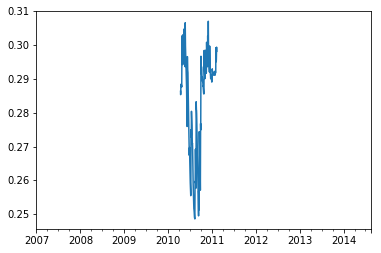

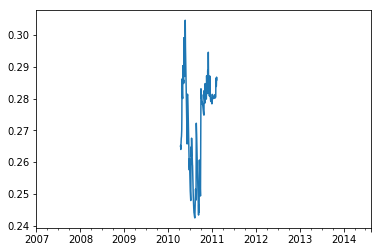

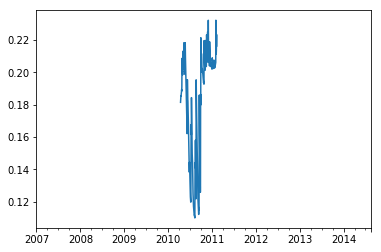

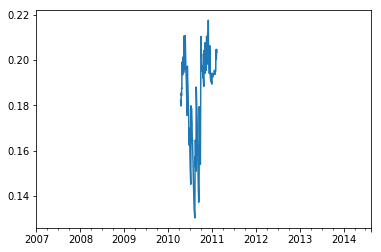

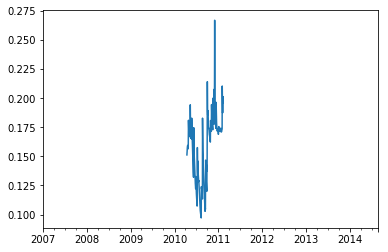

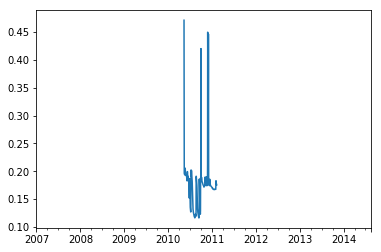

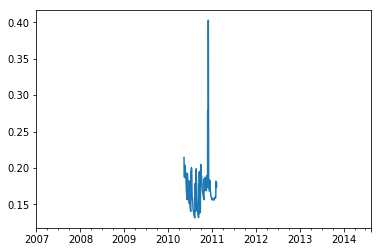

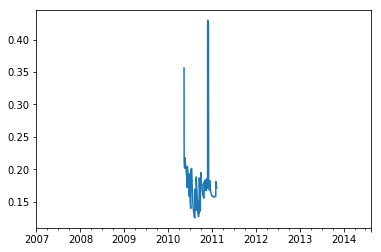

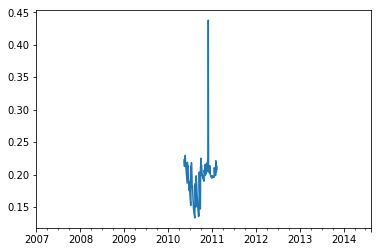

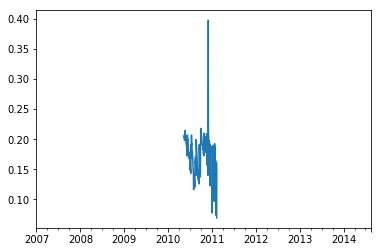

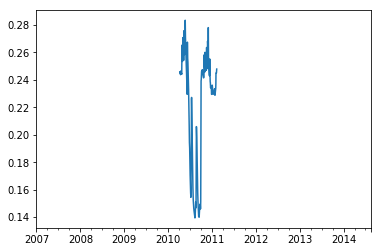

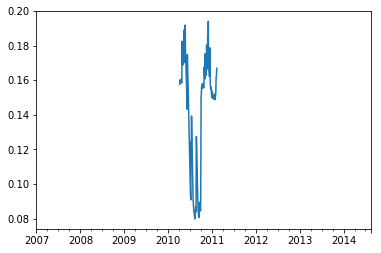

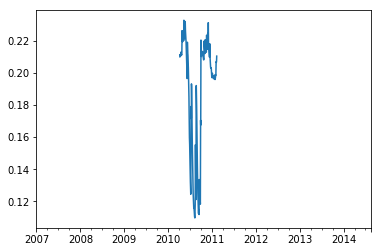

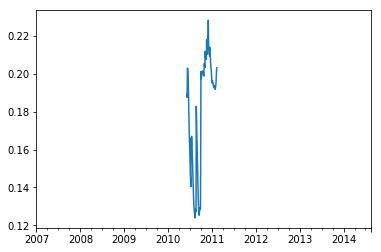

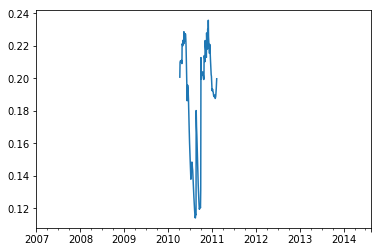

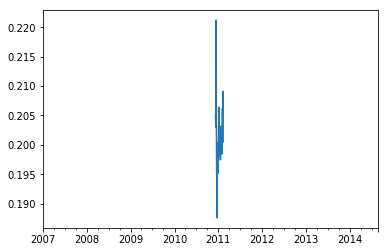

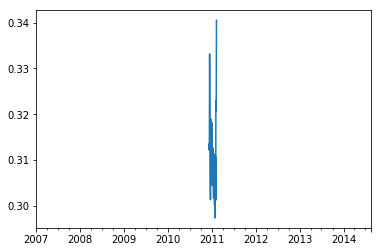

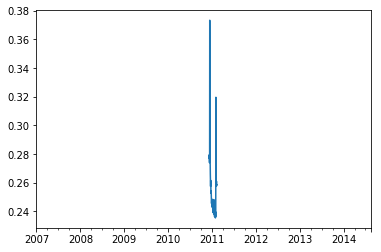

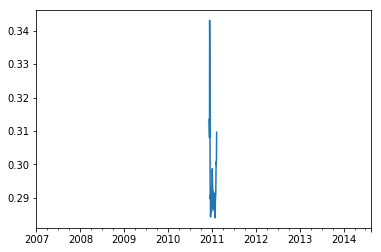

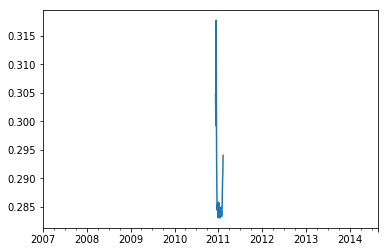

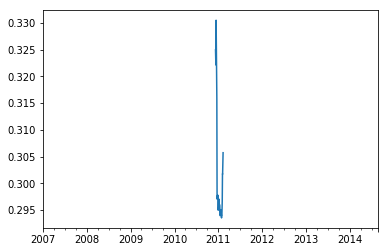

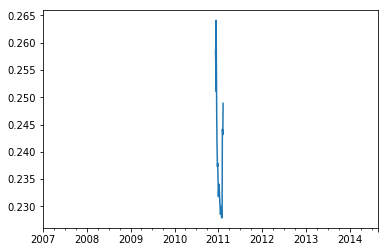

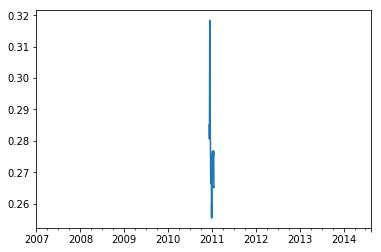

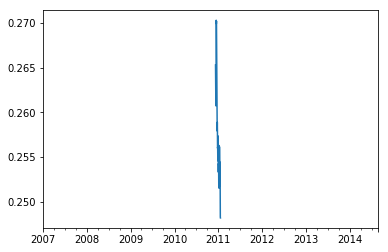

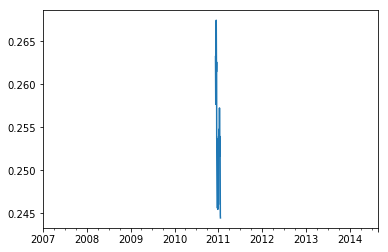

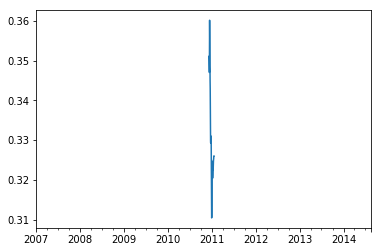

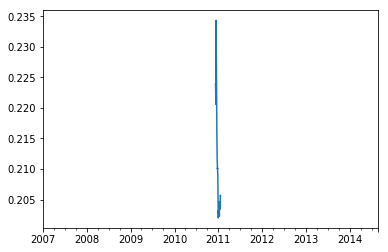

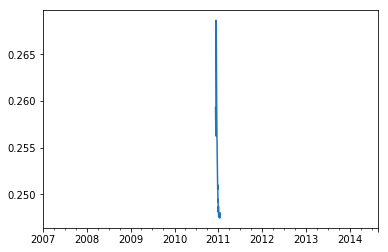

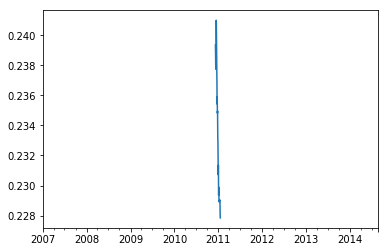

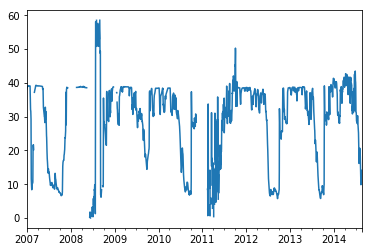

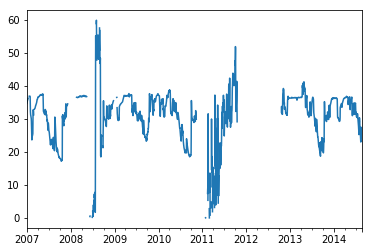

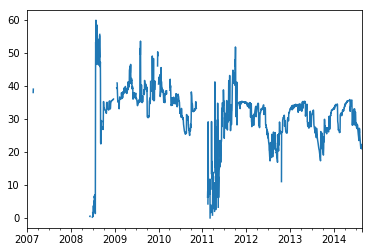

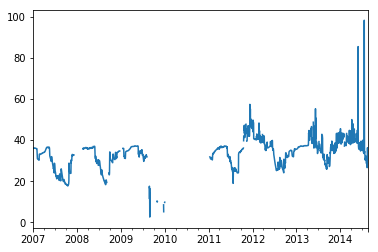

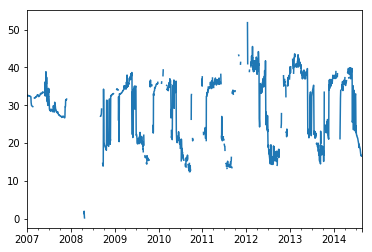

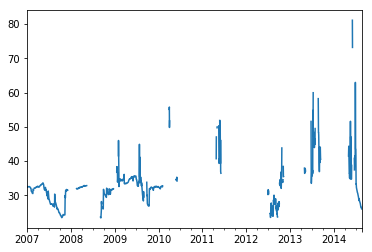

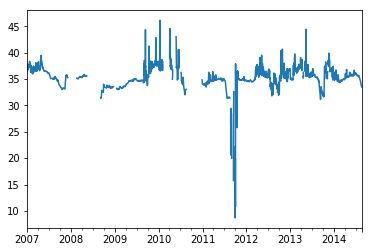

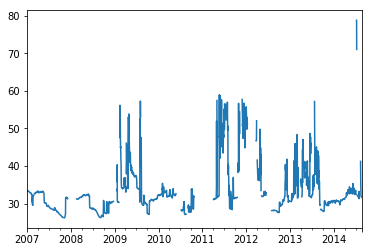

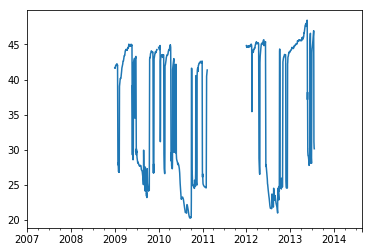

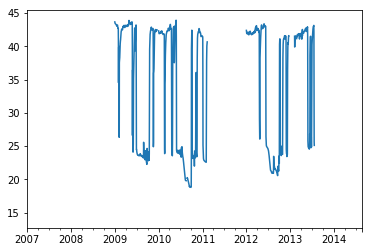

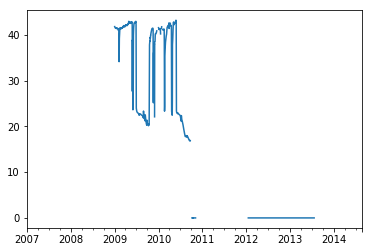

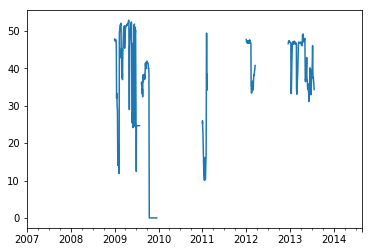

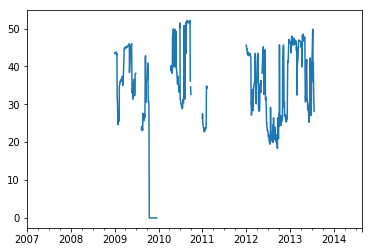

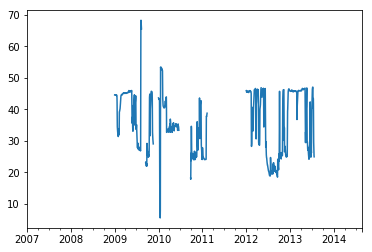

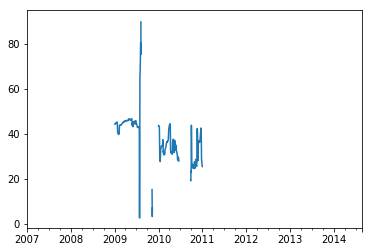

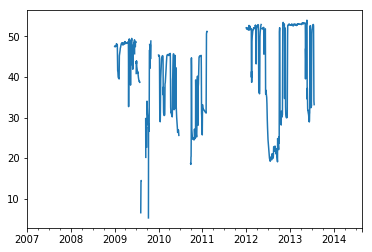

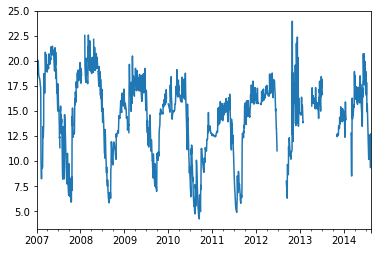

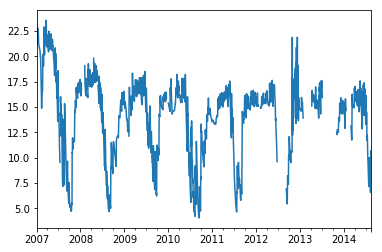

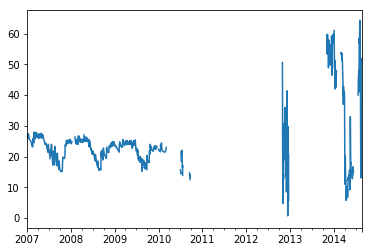

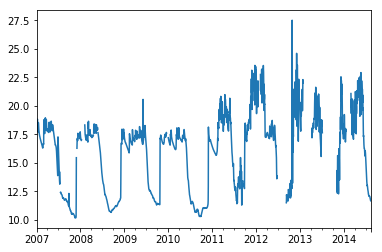

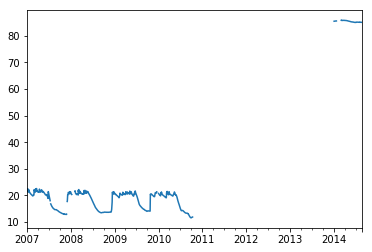

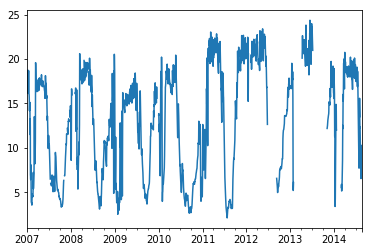

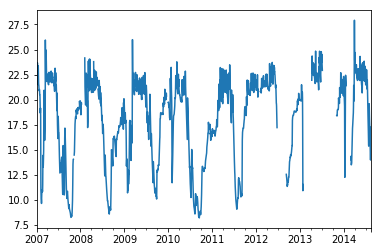

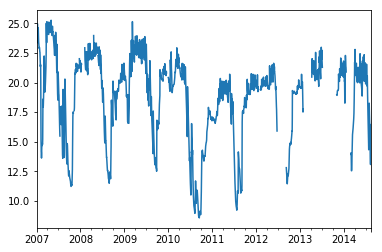

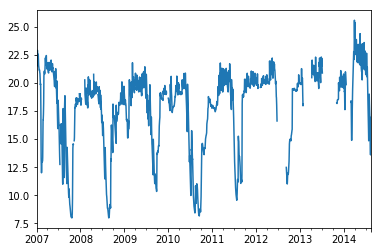

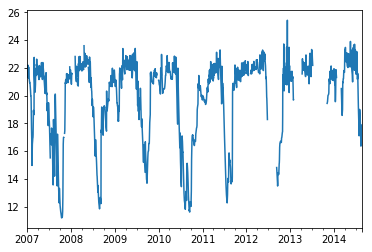

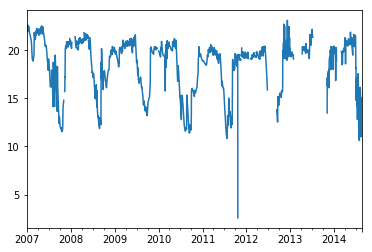

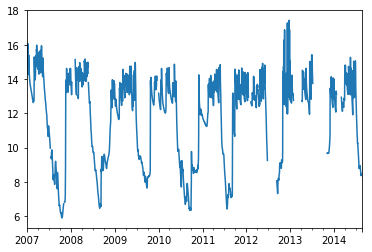

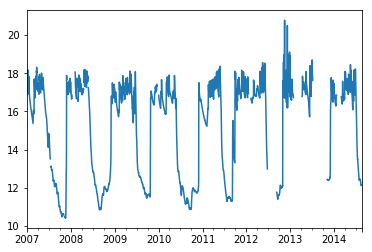

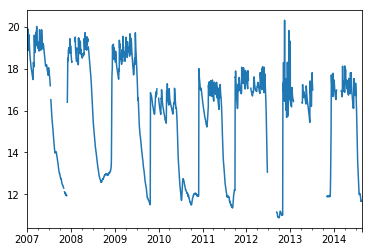

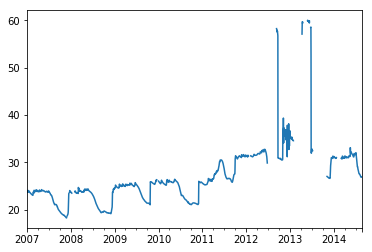

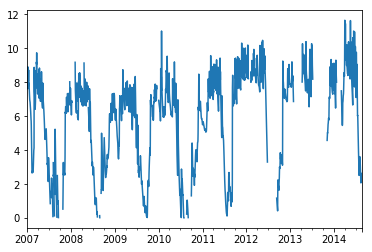

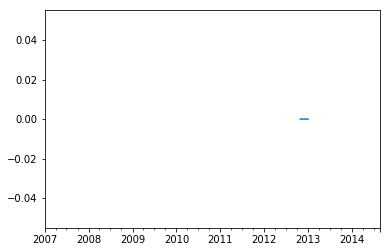

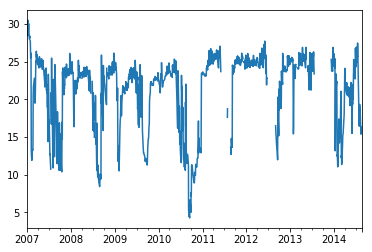

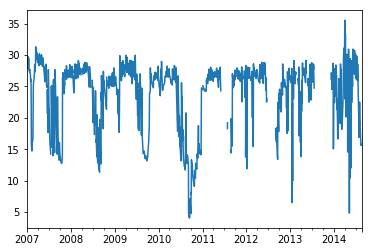

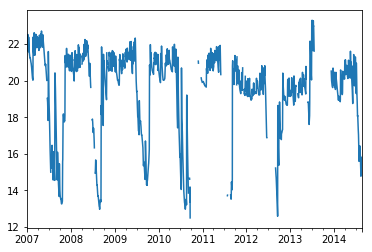

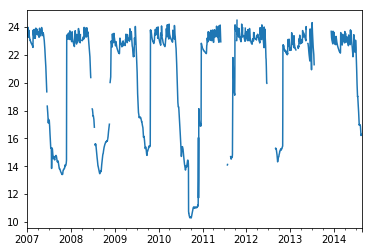

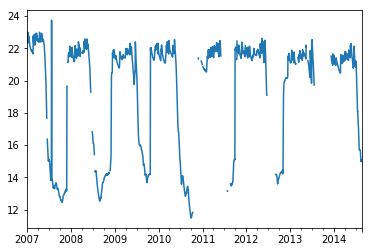

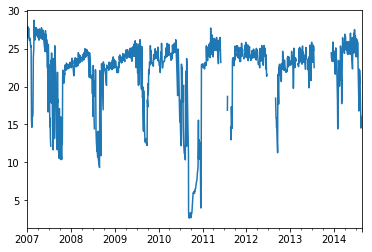

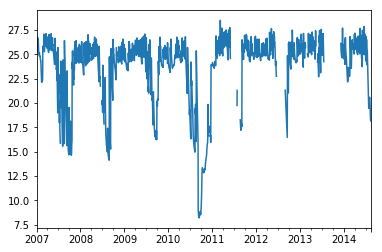

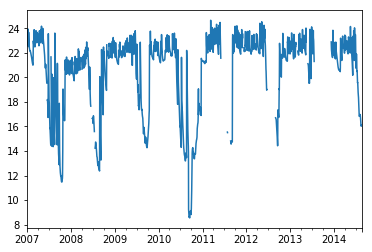

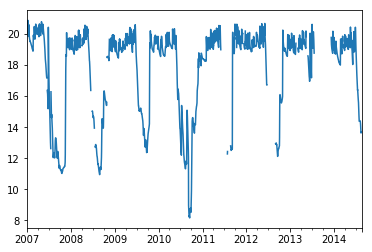

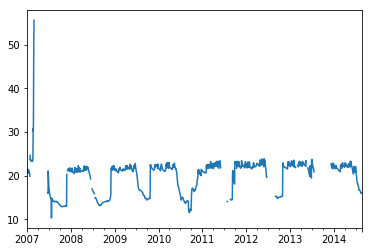

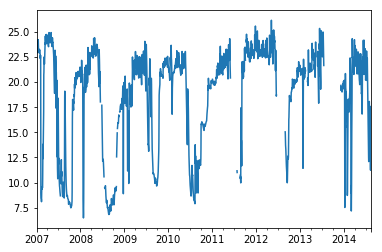

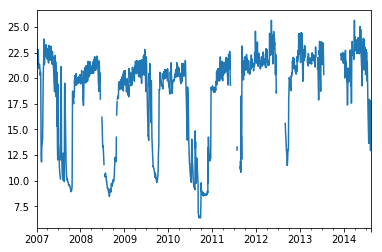

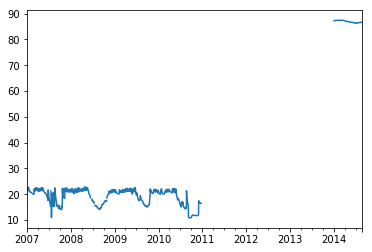

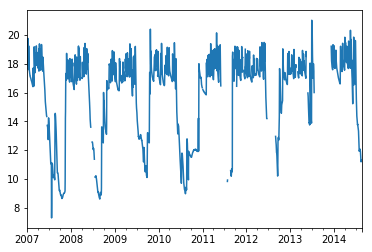

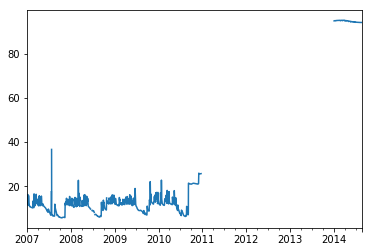

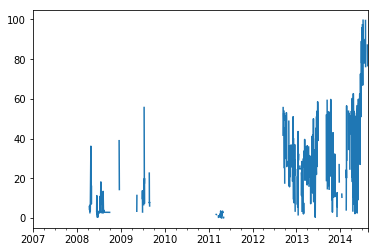

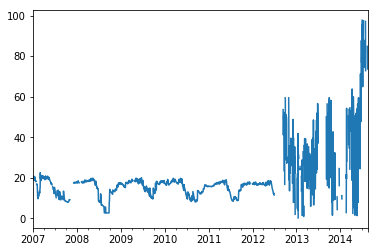

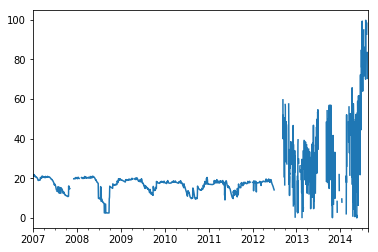

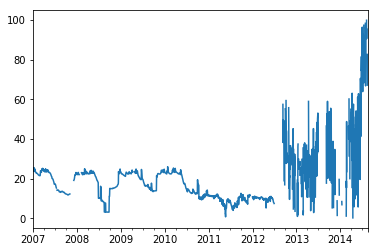

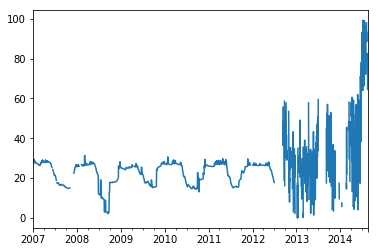

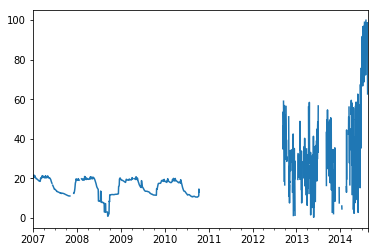

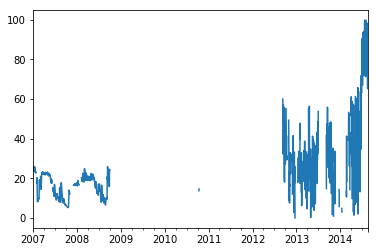

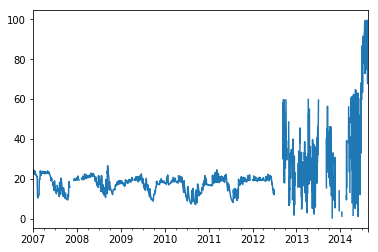

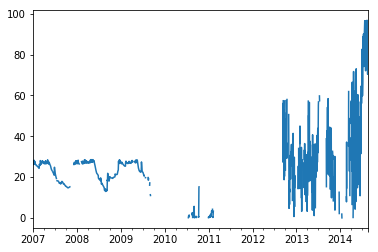

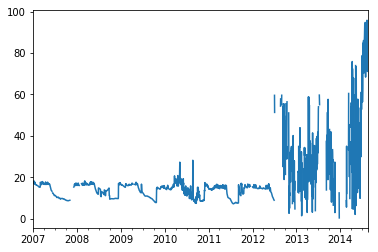

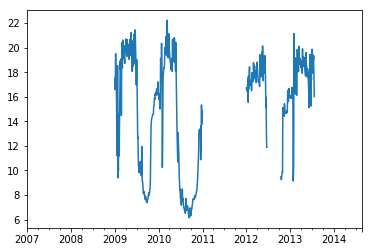

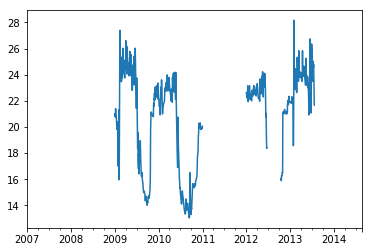

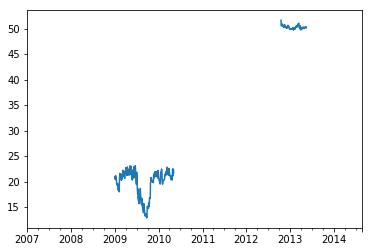

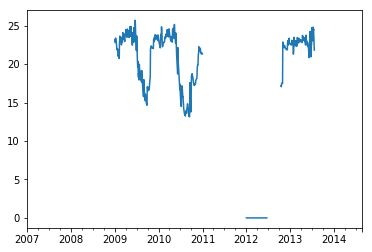

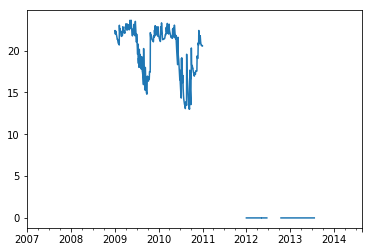

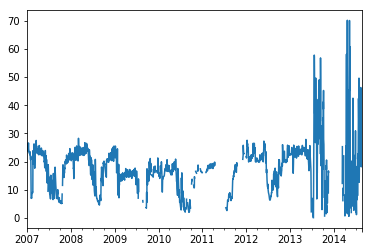

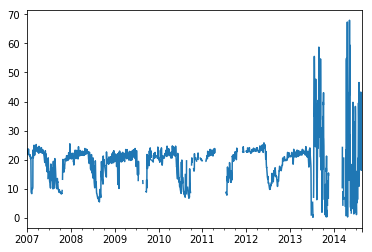

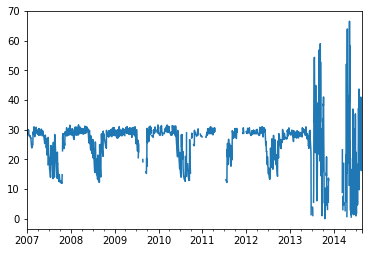

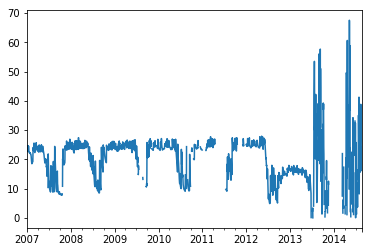

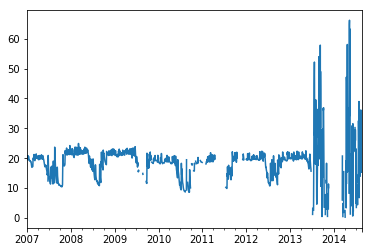

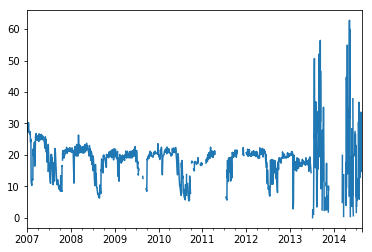

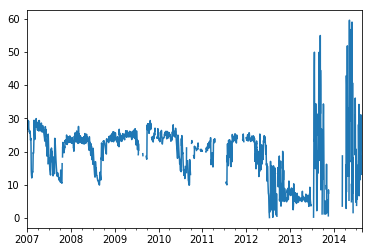

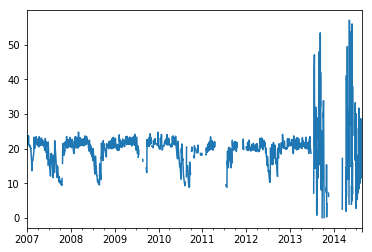

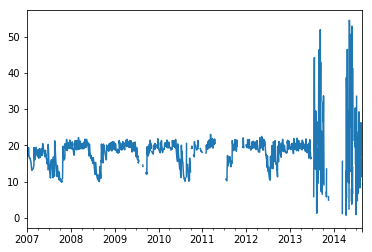

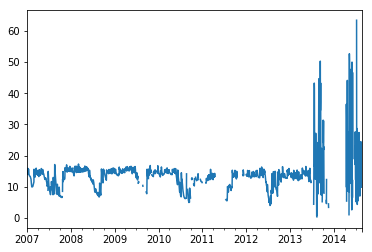

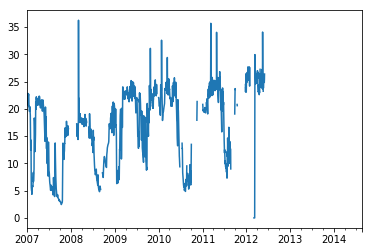

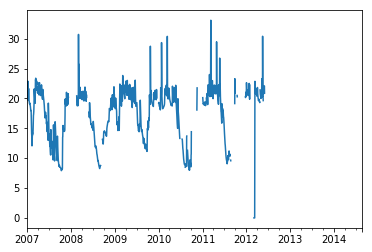

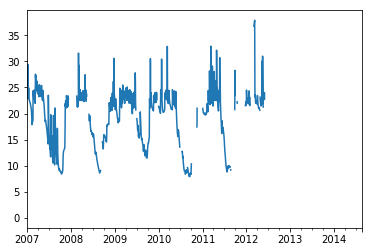

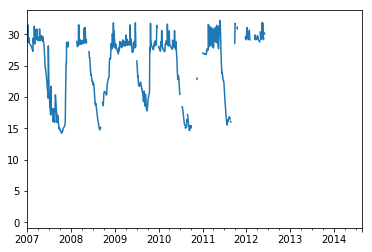

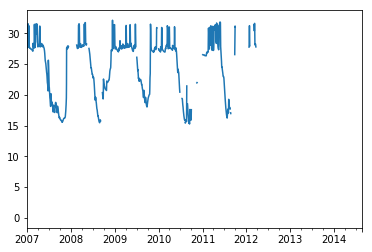

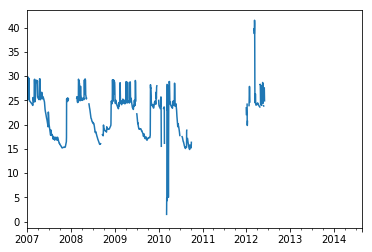

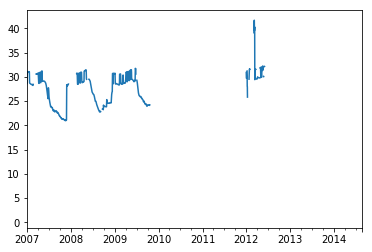

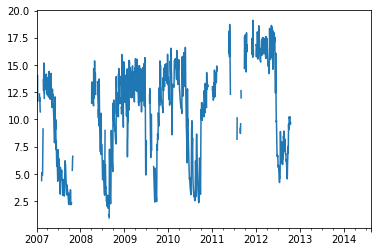

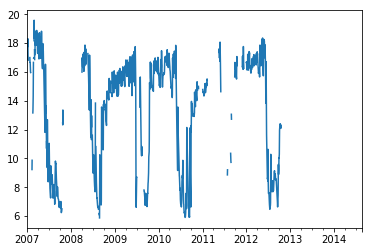

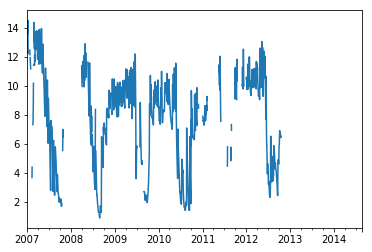

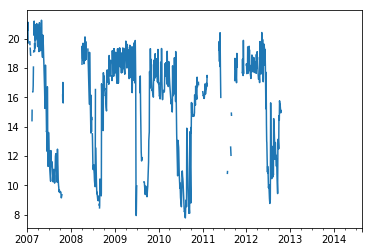

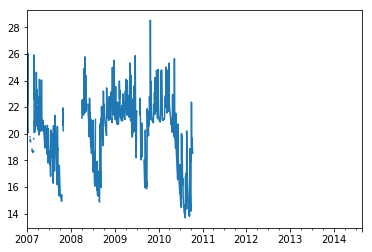

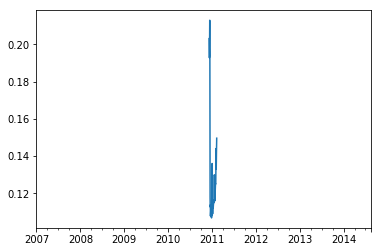

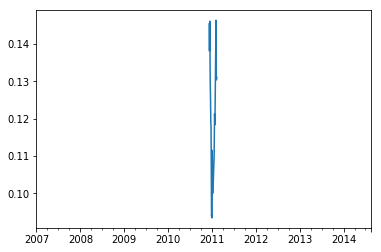

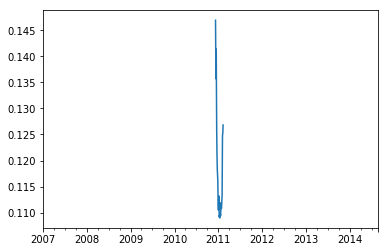

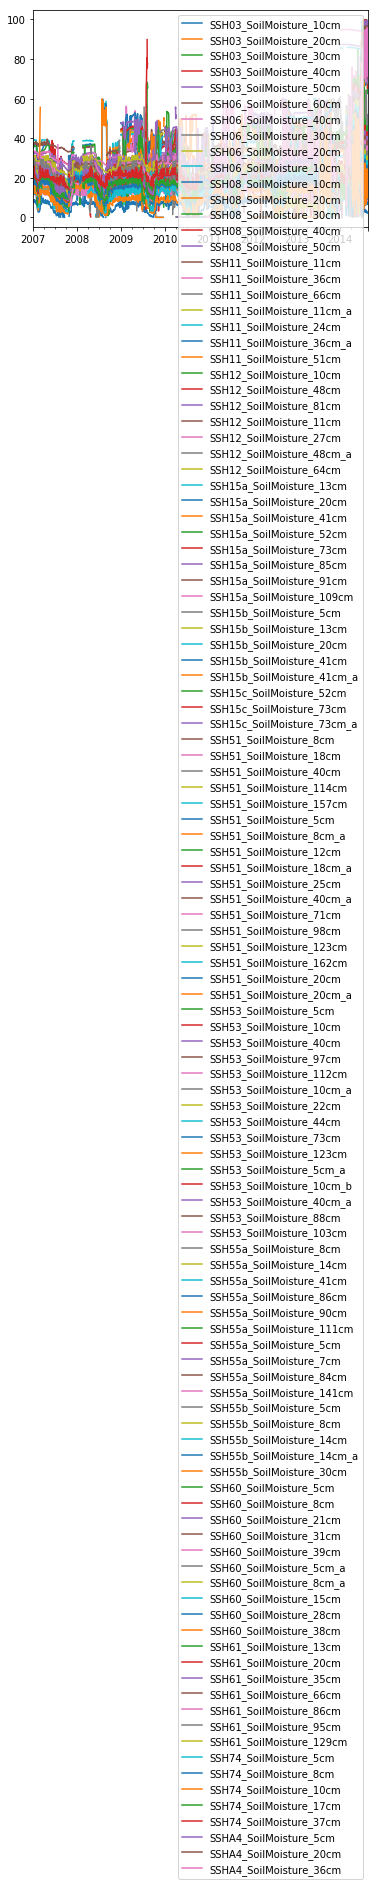

In [24]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    plt.figure()
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
    df[site].plot()   
    
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()
SoilMoisture.head()

### 12. SoilTemperature

In [25]:
siteList = ['03','06','08','11','12','15a','15b','15c','51','53','55a','55b','60','61','74','A4']

In [26]:
for i in siteList:
    print(i)
    data = pd.read_csv(path + 'SSHCZOHPSoilTemp'+i+'.csv', 
                   header = 0,index_col = 'TmStamp',
                     parse_dates = True, 
                   infer_datetime_format = True)
    data.index = pd.to_datetime(data.index)
    data.columns = ['SSH'+i+'_SoilTemperature_'+k for k in data.columns]
    data = threC(data,'SoilTemperature')
    data = data.groupby(data.index.date).mean()
    if i ==siteList[0]:
        prep = data
    else:
        prep = pd.concat([prep,data], axis=1,sort = True)
    display(prep.head(2))

03


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2010-04-14                   10.844211                   10.490526   
2010-04-15                    9.543056                    9.417014   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2010-04-14                    9.831579                    9.632631   
2010-04-15                    8.936806                    9.016667   

            SSH03_SoilTemperature_50cm  
2010-04-14                    9.201053  
2010-04-15                    8.760069

06


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2010-04-14                   10.844211                   10.490526   
2010-04-15                    9.543056                    9.417014   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2010-04-14                    9.831579                    9.632631   
2010-04-15                    8.936806                    9.016667   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2010-04-14                    9.201053                         NaN   
2010-04-15                    8.760069                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2010-04-14                         NaN                         NaN   
2010-04-15                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  
2010-04-14                         NaN                         NaN  
2010-04-15                         NaN                         NaN

08


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH08_SoilTemperature_10cm  SSH08_SoilTemperature_20cm  \
2010-04-08                   13.189344                   11.889344   
2010-04-09                   10.763889                   10.526389   

            SSH08_SoilTemperature_30cm  SSH08_SoilTemperature_40cm  \
2010-04-08                   11.664754                         NaN   
2010-04-09                   10.833333                         NaN   

            SSH08_SoilTemperature_50cm  
2010-04-08                    9.959016  
2010-04-09                    9.819097

11


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2010-04-08                         NaN                         NaN  ...   
2010-04-09                         NaN                         NaN  ...   

            SSH08_SoilTemperature_30cm  SSH08_SoilTemperature_40cm  \
2010-04-08                   11.664754                         NaN   
2010-04-09                   10.833333                         NaN   

            SSH08_SoilTemperature_50cm  SSH11_SoilTemperature_11cm  \
2010-04-08                    9.959016                         NaN   
2010-04-09                    9.819097                         NaN   

            SSH11_SoilTemperature_36cm  SSH11_SoilTemperature_66cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH11_SoilTemperature_11cm_a  SSH11_SoilTemperature_24cm  \
2010-04-08                           NaN                         NaN   
2010-04-09                           NaN                         NaN   

            SSH11_SoilTemperature_36cm_a  SSH11_SoilTemperature_51cm  
2010-04-08                           NaN                         NaN  
2010-04-09                           NaN                         NaN  

[2 rows x 22 columns]

12


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2010-04-08                         NaN                         NaN  ...   
2010-04-09                         NaN                         NaN  ...   

            SSH11_SoilTemperature_24cm  SSH11_SoilTemperature_36cm_a  \
2010-04-08                         NaN                           NaN   
2010-04-09                         NaN                           NaN   

            SSH11_SoilTemperature_51cm  SSH12_SoilTemperature_10cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH12_SoilTemperature_48cm  SSH12_SoilTemperature_81cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH12_SoilTemperature_11cm  SSH12_SoilTemperature_27cm  \
2010-04-08                         NaN                         NaN   
2010-04-09                         NaN                         NaN   

            SSH12_SoilTemperature_48cm_a  SSH12_SoilTemperature_64cm  
2010-04-08                           NaN                         NaN  
2010-04-09                           NaN                         NaN  

[2 rows x 29 columns]

15a


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH12_SoilTemperature_48cm_a  SSH12_SoilTemperature_64cm  \
2007-01-01                           NaN                         NaN   
2007-01-02                           NaN                         NaN   

            SSH15a_SoilTemperature_12cm  SSH15a_SoilTemperature_20cm  \
2007-01-01                     5.864424                     5.996063   
2007-01-02                     5.743840                     6.253417   

            SSH15a_SoilTemperature_36cm  SSH15a_SoilTemperature_52cm  \
2007-01-01                     6.227472                     6.325958   
2007-01-02                     6.575625                     6.655979   

            SSH15a_SoilTemperature_74cm  SSH15a_SoilTemperature_85cm  \
2007-01-01                     6.461278                     6.517507   
2007-01-02                     6.648958                     6.679201   

            SSH15a_SoilTemperature_91cm  SSH15a_SoilTemperature_105cm  
2007-01-01                     6.457076                      6.540556  
2007-01-02                     6.601826                      6.657201  

[2 rows x 37 columns]

15b


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH15a_SoilTemperature_52cm  SSH15a_SoilTemperature_74cm  \
2007-01-01                     6.325958                     6.461278   
2007-01-02                     6.655979                     6.648958   

            SSH15a_SoilTemperature_85cm  SSH15a_SoilTemperature_91cm  \
2007-01-01                     6.517507                     6.457076   
2007-01-02                     6.679201                     6.601826   

            SSH15a_SoilTemperature_105cm  SSH15b_SoilTemperature_5cm  \
2007-01-01                      6.540556                         NaN   
2007-01-02                      6.657201                         NaN   

            SSH15b_SoilTemperature_13cm  SSH15b_SoilTemperature_20cm  \
2007-01-01                          NaN                          NaN   
2007-01-02                          NaN                          NaN   

            SSH15b_SoilTemperature_41cm  SSH15b_SoilTemperature_41cm_a  
2007-01-01                          NaN                            NaN  
2007-01-02                          NaN                            NaN  

[2 rows x 42 columns]

15c


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH15a_SoilTemperature_91cm  SSH15a_SoilTemperature_105cm  \
2007-01-01                     6.457076                      6.540556   
2007-01-02                     6.601826                      6.657201   

            SSH15b_SoilTemperature_5cm  SSH15b_SoilTemperature_13cm  \
2007-01-01                         NaN                          NaN   
2007-01-02                         NaN                          NaN   

            SSH15b_SoilTemperature_20cm  SSH15b_SoilTemperature_41cm  \
2007-01-01                          NaN                          NaN   
2007-01-02                          NaN                          NaN   

            SSH15b_SoilTemperature_41cm_a  SSH15c_SoilTemperature_52cm  \
2007-01-01                            NaN                          NaN   
2007-01-02                            NaN                          NaN   

            SSH15c_SoilTemperature_73cm  SSH15c_SoilTemperature_73cm_a  
2007-01-01                          NaN                            NaN  
2007-01-02                          NaN                            NaN  

[2 rows x 45 columns]

51


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH51_SoilTemperature_5cm  SSH51_SoilTemperature_8cm_a  \
2007-01-01                   4.394811                     4.095965   
2007-01-02                   3.376604                     3.610500   

            SSH51_SoilTemperature_12cm  SSH51_SoilTemperature_18cm_a  \
2007-01-01                    4.047811                      4.058510   
2007-01-02                    3.923174                      4.087819   

            SSH51_SoilTemperature_25cm  SSH51_SoilTemperature_40cm_a  \
2007-01-01                    4.161811                      4.452000   
2007-01-02                    4.278417                      4.488778   

            SSH51_SoilTemperature_71cm  SSH51_SoilTemperature_98cm  \
2007-01-01                    5.404280                    6.311140   
2007-01-02                    5.221236                    6.049792   

            SSH51_SoilTemperature_123cm  SSH51_SoilTemperature_162cm  
2007-01-01                     7.180070                     8.095175  
2007-01-02                     6.911465                     7.840347  

[2 rows x 60 columns]

53


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH53_SoilTemperature_10cm_a  SSH53_SoilTemperature_18cm  \
2007-01-01                      4.703444                    4.612319   
2007-01-02                      4.651708                    4.763979   

            SSH53_SoilTemperature_40cm_a  SSH53_SoilTemperature_69cm  \
2007-01-01                      5.235674                    6.256125   
2007-01-02                      5.277701                    6.114118   

            SSH53_SoilTemperature_121cm  SSH53_SoilTemperature_5cm_a  \
2007-01-01                     7.633264                     5.039715   
2007-01-02                     7.452354                     4.548715   

            SSH53_SoilTemperature_10cm_b  SSH53_SoilTemperature_40cm_b  \
2007-01-01                      4.975222                      5.657493   
2007-01-02                      4.870819                      5.750306   

            SSH53_SoilTemperature_86cm  SSH53_SoilTemperature_101cm  
2007-01-01                    7.132583                     7.663681  
2007-01-02                    7.081493                     7.625611  

[2 rows x 75 columns]

55a


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH55a_SoilTemperature_7cm  SSH55a_SoilTemperature_14cm  \
2007-01-01                    5.043930                     4.948671   
2007-01-02                    4.586583                     4.925437   

            SSH55a_SoilTemperature_44cm  SSH55a_SoilTemperature_75cm  \
2007-01-01                     5.539867                     6.402455   
2007-01-02                     5.638868                     6.297222   

            SSH55a_SoilTemperature_79cm  SSH55a_SoilTemperature_102cm  \
2007-01-01                          NaN                      6.572091   
2007-01-02                          NaN                      6.444604   

            SSH55a_SoilTemperature_5cm  SSH55a_SoilTemperature_7cm_a  \
2007-01-01                    7.175755                      5.464671   
2007-01-02                    7.001035                      4.480556   

            SSH55a_SoilTemperature_84cm  SSH55a_SoilTemperature_141cm  
2007-01-01                     5.368993                      6.806776  
2007-01-02                     4.753722                      6.640090  

[2 rows x 85 columns]

55b


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH55a_SoilTemperature_102cm  SSH55a_SoilTemperature_5cm  \
2007-01-01                      6.572091                    7.175755   
2007-01-02                      6.444604                    7.001035   

            SSH55a_SoilTemperature_7cm_a  SSH55a_SoilTemperature_84cm  \
2007-01-01                      5.464671                     5.368993   
2007-01-02                      4.480556                     4.753722   

            SSH55a_SoilTemperature_141cm  SSH55b_SoilTemperature_5cm  \
2007-01-01                      6.806776                         NaN   
2007-01-02                      6.640090                         NaN   

            SSH55b_SoilTemperature_8cm  SSH55b_SoilTemperature_14cm  \
2007-01-01                         NaN                          NaN   
2007-01-02                         NaN                          NaN   

            SSH55b_SoilTemperature_14cm_a  SSH55b_SoilTemperature_30cm  
2007-01-01                            NaN                          NaN  
2007-01-02                            NaN                          NaN  

[2 rows x 90 columns]

60


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH60_SoilTemperature_5cm  SSH60_SoilTemperature_8cm  \
2007-01-01                   5.072847                        NaN   
2007-01-02                   4.086243                        NaN   

            SSH60_SoilTemperature_29cm  SSH60_SoilTemperature_38cm  \
2007-01-01                    5.207167                    5.430736   
2007-01-02                    5.359368                    5.574639   

            SSH60_SoilTemperature_24cm  SSH60_SoilTemperature_5cm_a  \
2007-01-01                    5.009694                     4.877931   
2007-01-02                    5.145903                     4.132806   

            SSH60_SoilTemperature_11cm  SSH60_SoilTemperature_20cm  \
2007-01-01                         NaN                    4.915937   
2007-01-02                         NaN                    4.997708   

            SSH60_SoilTemperature_27cm  SSH60_SoilTemperature_31cm  
2007-01-01                    5.093785                    4.950896  
2007-01-02                    5.265875                    5.139660  

[2 rows x 100 columns]

61


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH60_SoilTemperature_20cm  SSH60_SoilTemperature_27cm  \
2007-01-01                    4.915937                    5.093785   
2007-01-02                    4.997708                    5.265875   

            SSH60_SoilTemperature_31cm  SSH61_SoilTemperature_10cm  \
2007-01-01                    4.950896                    4.684000   
2007-01-02                    5.139660                    2.674993   

            SSH61_SoilTemperature_20cm  SSH61_SoilTemperature_36cm  \
2007-01-01                    4.333750                    4.495799   
2007-01-02                    3.929354                    4.530937   

            SSH61_SoilTemperature_67cm  SSH61_SoilTemperature_87cm  \
2007-01-01                    5.423056                    6.147007   
2007-01-02                    5.300132                    5.918444   

            SSH61_SoilTemperature_97cm  SSH61_SoilTemperature_127cm  
2007-01-01                    6.483188                     7.304611  
2007-01-02                    6.227722                     6.989083  

[2 rows x 107 columns]

74


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH61_SoilTemperature_36cm  SSH61_SoilTemperature_67cm  \
2007-01-01                    4.495799                    5.423056   
2007-01-02                    4.530937                    5.300132   

            SSH61_SoilTemperature_87cm  SSH61_SoilTemperature_97cm  \
2007-01-01                    6.147007                    6.483188   
2007-01-02                    5.918444                    6.227722   

            SSH61_SoilTemperature_127cm  SSH74_SoilTemperature_5cm  \
2007-01-01                     7.304611                   5.651056   
2007-01-02                     6.989083                   4.997771   

            SSH74_SoilTemperature_8cm  SSH74_SoilTemperature_9cm  \
2007-01-01                   5.624278                   5.660201   
2007-01-02                   4.906958                   5.234097   

            SSH74_SoilTemperature_23cm  SSH74_SoilTemperature_40cm  
2007-01-01                    5.878764                    6.143924  
2007-01-02                    5.649625                    5.900861  

[2 rows x 112 columns]

A4


SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   

            SSH61_SoilTemperature_97cm  SSH61_SoilTemperature_127cm  \
2007-01-01                    6.483188                     7.304611   
2007-01-02                    6.227722                     6.989083   

            SSH74_SoilTemperature_5cm  SSH74_SoilTemperature_8cm  \
2007-01-01                   5.651056                   5.624278   
2007-01-02                   4.997771                   4.906958   

            SSH74_SoilTemperature_9cm  SSH74_SoilTemperature_23cm  \
2007-01-01                   5.660201                    5.878764   
2007-01-02                   5.234097                    5.649625   

            SSH74_SoilTemperature_40cm  SSHA4_SoilTemperature_5cm  \
2007-01-01                    6.143924                        NaN   
2007-01-02                    5.900861                        NaN   

            SSHA4_SoilTemperature_20cm  SSHA4_SoilTemperature_36cm  
2007-01-01                         NaN                         NaN  
2007-01-02                         NaN                         NaN  

[2 rows x 115 columns]

SSH03_SoilTemperature_10cm
SSH03_SoilTemperature_20cm
SSH03_SoilTemperature_30cm
SSH03_SoilTemperature_40cm
SSH03_SoilTemperature_50cm
SSH06_SoilTemperature_60cm
SSH06_SoilTemperature_40cm
SSH06_SoilTemperature_30cm
SSH06_SoilTemperature_20cm
SSH06_SoilTemperature_10cm
SSH08_SoilTemperature_10cm
SSH08_SoilTemperature_20cm
SSH08_SoilTemperature_30cm
SSH08_SoilTemperature_40cm
SSH08_SoilTemperature_50cm
SSH11_SoilTemperature_11cm
SSH11_SoilTemperature_36cm
SSH11_SoilTemperature_66cm
SSH11_SoilTemperature_11cm_a
SSH11_SoilTemperature_24cm
SSH11_SoilTemperature_36cm_a
SSH11_SoilTemperature_51cm
SSH12_SoilTemperature_10cm
SSH12_SoilTemperature_48cm
SSH12_SoilTemperature_81cm
SSH12_SoilTemperature_11cm
SSH12_SoilTemperature_27cm
SSH12_SoilTemperature_48cm_a
SSH12_SoilTemperature_64cm
SSH15a_SoilTemperature_12cm
SSH15a_SoilTemperature_20cm
SSH15a_SoilTemperature_36cm
SSH15a_SoilTemperature_52cm
SSH15a_SoilTemperature_74cm
SSH15a_SoilTemperature_85cm
SSH15a_SoilTemperature_91cm
SSH15a_SoilTemp

SSH03_SoilTemperature_10cm  SSH03_SoilTemperature_20cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   
2007-01-03                         NaN                         NaN   
2007-01-04                         NaN                         NaN   
2007-01-05                         NaN                         NaN   

            SSH03_SoilTemperature_30cm  SSH03_SoilTemperature_40cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   
2007-01-03                         NaN                         NaN   
2007-01-04                         NaN                         NaN   
2007-01-05                         NaN                         NaN   

            SSH03_SoilTemperature_50cm  SSH06_SoilTemperature_60cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   
2007-01-03                         NaN                         NaN   
2007-01-04                         NaN                         NaN   
2007-01-05                         NaN                         NaN   

            SSH06_SoilTemperature_40cm  SSH06_SoilTemperature_30cm  \
2007-01-01                         NaN                         NaN   
2007-01-02                         NaN                         NaN   
2007-01-03                         NaN                         NaN   
2007-01-04                         NaN                         NaN   
2007-01-05                         NaN                         NaN   

            SSH06_SoilTemperature_20cm  SSH06_SoilTemperature_10cm  ...  \
2007-01-01                         NaN                         NaN  ...   
2007-01-02                         NaN                         NaN  ...   
2007-01-03                         NaN                         NaN  ...   
2007-01-04                         NaN                         NaN  ...   
2007-01-05                         NaN                         NaN  ...   

            SSH61_SoilTemperature_97cm  SSH61_SoilTemperature_127cm  \
2007-01-01                    6.483188                     7.304611   
2007-01-02                    6.227722                     6.989083   
2007-01-03                    6.287229                     7.009250   
2007-01-04                    6.465639                     7.226201   
2007-01-05                    6.537125                     7.350278   

            SSH74_SoilTemperature_5cm  SSH74_SoilTemperature_8cm  \
2007-01-01                   5.651056                   5.624278   
2007-01-02                   4.997771                   4.906958   
2007-01-03                   4.068069                   4.078403   
2007-01-04                   3.963902                   4.065735   
2007-01-05                        NaN                        NaN   

            SSH74_SoilTemperature_9cm  SSH74_SoilTemperature_23cm  \
2007-01-01                   5.660201                    5.878764   
2007-01-02                   5.234097                    5.649625   
2007-01-03                   4.428694                    5.208306   
2007-01-04                   4.330951                    5.285294   
2007-01-05                        NaN                         NaN   

            SSH74_SoilTemperature_40cm  SSHA4_SoilTemperature_5cm  \
2007-01-01                    6.143924                        NaN   
2007-01-02                    5.900861                        NaN   
2007-01-03                    5.728889                        NaN   
2007-01-04                    5.910784                        NaN   
2007-01-05                         NaN                        NaN   

            SSHA4_SoilTemperature_20cm  SSHA4_SoilTemperature_36cm  
2007-01-01                         NaN                         NaN  
2007-01-02                         NaN                         NaN  
2007

<Figure size 720x288 with 0 Axes>

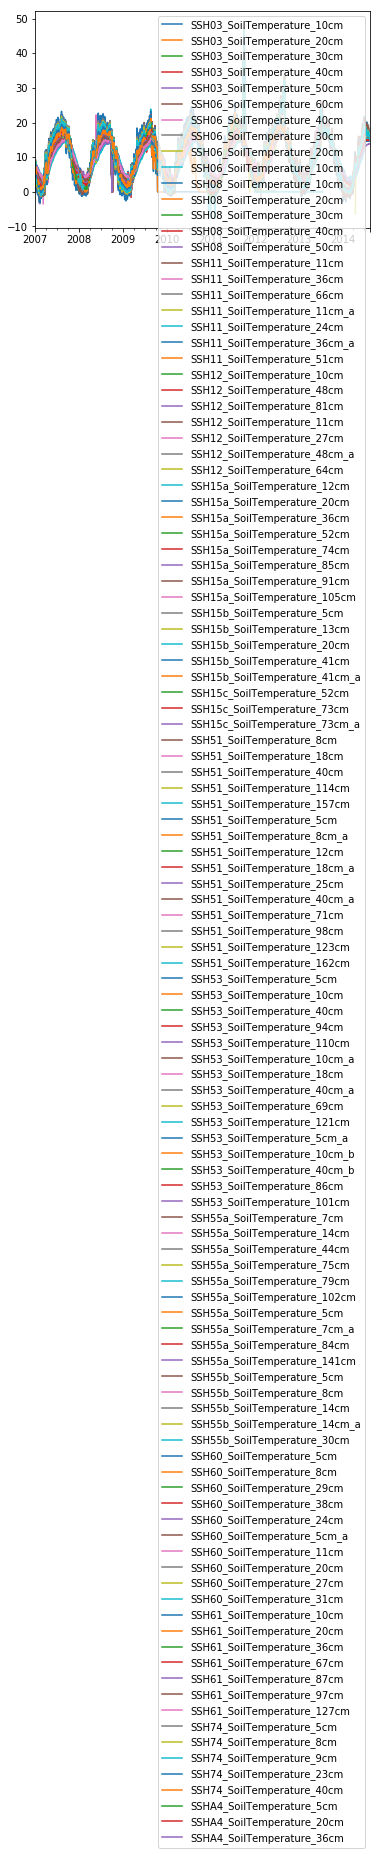

In [27]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head()

### 12. Isotope

In [28]:
# Streamflow
data1 = pd.read_excel('http://www.czo.psu.edu/downloads/IsotopePublishing/StreamWater/Stream_Water_Isotopes_all.xlsx',
                    header = 0,skiprows = 1,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data1.head(2)

Calendar Season Sample d2H Reportable Value (permil)  \
Date                                                              
2008-03-28          Spring  CZO 1                           -54   
2008-03-29          Spring      2                           -54   

            d2H Standard Deviation (permil)  d18O Reportable Value (permil)  \
Date                                                                          
2008-03-28                              NaN                            -9.6   
2008-03-29                              NaN                           -10.0   

            d18O Standard Deviation (permil)  Discharge (cmd)  
Date                                                           
2008-03-28                               NaN       105.480278  
2008-03-29                               NaN       105.239514

In [29]:
prep1 = copy.deepcopy(data1[['d2H Reportable Value (permil)','d18O Reportable Value (permil)']])
prep1.columns = ['ShaleHill_Isotope_2H_discharge','ShaleHill_Isotope_18O_discharge']
#prep1 = prep1.groupby(prep1.index.date).mean()
display(prep1.head(3))
prep1.tail(3)

ShaleHill_Isotope_2H_discharge  ShaleHill_Isotope_18O_discharge
Date                                                                      
2008-03-28                            -54                             -9.6
2008-03-29                            -54                            -10.0
2008-03-30                            -53                             -9.6

ShaleHill_Isotope_2H_discharge  ShaleHill_Isotope_18O_discharge
Date                                                                      
2011-12-29                       -55.5247                        -8.649233
2011-12-30                       -53.7628                        -8.329236
2011-12-31                       -54.4138                        -8.396875

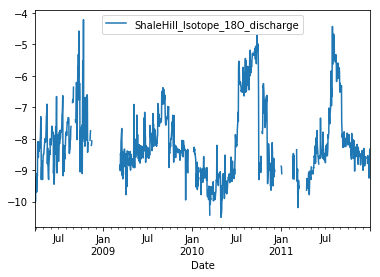

In [30]:
prep1.plot()

In [31]:
# Precipitation
data2 = pd.read_excel('http://www.czo.psu.edu/downloads/IsotopePublishing/Precipitation/Precipitation_Isotopes_all.xlsx',
                    header = 0,skiprows = 1,index_col = 'Date \nCollected',parse_dates = True, infer_datetime_format = True)
data2.head(2)

Sample  d2H Reportable Value (permil)  \
Date \nCollected                                              
2008-12-03        GHNSA011-4                     -89.150668   
2008-12-03        GHNSA012-5                     -95.472552   

                  d2H Standard Deviation (permil)  \
Date \nCollected                                    
2008-12-03                                    NaN   
2008-12-03                                    NaN   

                  d18O Reportable Value (permil)  \
Date \nCollected                                   
2008-12-03                            -13.638154   
2008-12-03                            -14.594285   

                  d18O Standard Deviation (permil)  Unnamed: 6  Date of Event  \
Date \nCollected                                                                
2008-12-03                                     NaN         NaN  Missing data.   
2008-12-03                                     NaN         NaN            NaN   

                 Calendar Season Time Event Began Start - End of Collection  \
Date \nCollected                                                              
2008-12-03                   NaN              NaN                       NaN   
2008-12-03                   NaN              NaN                       NaN   

                 Duration of Collection (HR:MM)  Amount from Disdrometer (mm)  
Date \nCollected                                                               
2008-12-03                                  NaN                           NaN  
2008-12-03                                  NaN                           NaN

In [32]:
prep2 = copy.deepcopy(data2[['d2H Reportable Value (permil)','d18O Reportable Value (permil)']])
prep2.columns = ['ShaleHill_Isotope_2H_precipitation','ShaleHill_Isotope_18O_precipitation']
prep2 = prep2.groupby(prep2.index.date).mean()
display(prep2.head(3))
prep2.tail(3)

ShaleHill_Isotope_2H_precipitation  \
2008-12-03                          -92.974213   
2008-12-12                          -85.207638   
2008-12-23                          -58.258164   

            ShaleHill_Isotope_18O_precipitation  
2008-12-03                           -14.327900  
2008-12-12                           -11.097982  
2008-12-23                            -8.710031

ShaleHill_Isotope_2H_precipitation  \
2011-12-02                          -29.581824   
2011-12-14                          -24.394303   
2011-12-21                          -39.459495   

            ShaleHill_Isotope_18O_precipitation  
2011-12-02                            -5.647726  
2011-12-14                            -4.534314  
2011-12-21                            -5.488279

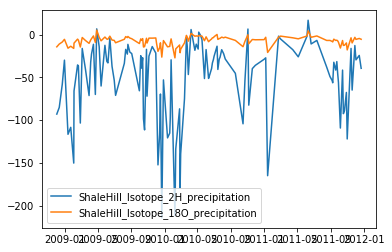

In [33]:
prep2.plot()

In [34]:
prep = copy.deepcopy(prep1.join(prep2,how ='outer'))
for i in prep.columns.values:
    prep[i] = prep[i].apply(lambda x: x if type(x)==float else None)   
prep = threC(prep, 'Isotope')


ShaleHill_Isotope_2H_discharge  ShaleHill_Isotope_18O_discharge  \
2008-03-28                             NaN                             -9.6   
2008-03-29                             NaN                            -10.0   
2008-03-30                             NaN                             -9.6   
2008-03-31                             NaN                             -9.5   
2008-04-01                             NaN                             -9.6   

            ShaleHill_Isotope_2H_precipitation  \
2008-03-28                                 NaN   
2008-03-29                                 NaN   
2008-03-30                                 NaN   
2008-03-31                                 NaN   
2008-04-01                                 NaN   

            ShaleHill_Isotope_18O_precipitation  
2008-03-28                                  NaN  
2008-03-29                                  NaN  
2008-03-30                                  NaN  
2008-03-31                                  NaN  
2008-04-01                                  NaN

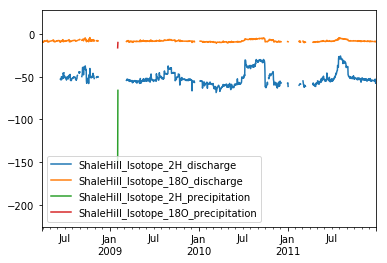

In [35]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1])) 

ready_columns = pd.unique(prep.columns)
NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

for i in np.arange(len(ready_columns)):
    #print(ready_columns[i])
    tab = prep[ready_columns[i]]
    for j in np.arange(len(tab)):
        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]
        
Isotope = copy.deepcopy(df)
Isotope.plot()
Isotope.head()

## Result

In [36]:
result1 = pd.concat([Discharge, Precipitation,AirTemperature,SolarRadiation,RelativeHumidity,  # SnowDepth,
                   SoilMoisture,SoilTemperature],
                    axis=1,
                    join='outer')



In [37]:
# Write data to csv for further inspection
result1.index.rename('DateTime', inplace = True)
result1.head(3)

ShaleHill_Discharge  ShaleHill_Precipitation  \
DateTime                                                   
2006-01-01             1.050735                      0.7   
2006-01-02             1.064477                     12.1   
2006-01-03             2.552341                      1.9   

            SSH11_AirTemperature  SSH12_AirTemperature  SSH51_AirTemperature  \
DateTime                                                                       
2006-01-01                   NaN                   NaN                   NaN   
2006-01-02                   NaN                   NaN                   NaN   
2006-01-03                   NaN                   NaN                   NaN   

            SSH60_AirTemperature  SHFluxTower_SolarRadiation  \
DateTime                                                       
2006-01-01                   NaN                         NaN   
2006-01-02                   NaN                         NaN   
2006-01-03                   NaN                         NaN   

            SHFluxTower_RelativeHumidity  SSH03_SoilMoisture_10cm  \
DateTime                                                            
2006-01-01                           NaN                      NaN   
2006-01-02                           NaN                      NaN   
2006-01-03                           NaN                      NaN   

            SSH03_SoilMoisture_20cm  ...  SSH61_SoilTemperature_97cm  \
DateTime                             ...                               
2006-01-01                      NaN  ...                         NaN   
2006-01-02                      NaN  ...                         NaN   
2006-01-03                      NaN  ...                         NaN   

            SSH61_SoilTemperature_127cm  SSH74_SoilTemperature_5cm  \
DateTime                                                             
2006-01-01                          NaN                        NaN   
2006-01-02                          NaN                        NaN   
2006-01-03                          NaN                        NaN   

            SSH74_SoilTemperature_8cm  SSH74_SoilTemperature_9cm  \
DateTime                                                           
2006-01-01                        NaN                        NaN   
2006-01-02                        NaN                        NaN   
2006-01-03                        NaN                        NaN   

            SSH74_SoilTemperature_23cm  SSH74_SoilTemperature_40cm  \
DateTime                                                             
2006-01-01                         NaN                         NaN   
2006-01-02                         NaN                         NaN   
2006-01-03                         NaN                         NaN   

            SSHA4_SoilTemperature_5cm  SSHA4_SoilTemperature_20cm  \
DateTime                                                            
2006-01-01                        NaN                         NaN   
2006-01-02                        NaN                         NaN   
2006-01-03                        NaN                         NaN   

            SSHA4_SoilTemperature_36cm  
DateTime                                
2006-01-01                         NaN  
2006-01-02                         NaN  
2006-01-03                         NaN  

[3 rows x 240 columns]

In [38]:
result1.tail(3)

ShaleHill_Discharge  ShaleHill_Precipitation  \
DateTime                                                   
2018-12-29                  NaN                     15.7   
2018-12-30                  NaN                      0.2   
2018-12-31                  NaN                      0.0   

            SSH11_AirTemperature  SSH12_AirTemperature  SSH51_AirTemperature  \
DateTime                                                                       
2018-12-29                   NaN                   NaN                   NaN   
2018-12-30                   NaN                   NaN                   NaN   
2018-12-31                   NaN                   NaN                   NaN   

            SSH60_AirTemperature  SHFluxTower_SolarRadiation  \
DateTime                                                       
2018-12-29                   NaN                         NaN   
2018-12-30                   NaN                         NaN   
2018-12-31                   NaN                         NaN   

            SHFluxTower_RelativeHumidity  SSH03_SoilMoisture_10cm  \
DateTime                                                            
2018-12-29                           NaN                      NaN   
2018-12-30                           NaN                      NaN   
2018-12-31                           NaN                      NaN   

            SSH03_SoilMoisture_20cm  ...  SSH61_SoilTemperature_97cm  \
DateTime                             ...                               
2018-12-29                      NaN  ...                         NaN   
2018-12-30                      NaN  ...                         NaN   
2018-12-31                      NaN  ...                         NaN   

            SSH61_SoilTemperature_127cm  SSH74_SoilTemperature_5cm  \
DateTime                                                             
2018-12-29                          NaN                        NaN   
2018-12-30                          NaN                        NaN   
2018-12-31                          NaN                        NaN   

            SSH74_SoilTemperature_8cm  SSH74_SoilTemperature_9cm  \
DateTime                                                           
2018-12-29                        NaN                        NaN   
2018-12-30                        NaN                        NaN   
2018-12-31                        NaN                        NaN   

            SSH74_SoilTemperature_23cm  SSH74_SoilTemperature_40cm  \
DateTime                                                             
2018-12-29                         NaN                         NaN   
2018-12-30                         NaN                         NaN   
2018-12-31                         NaN                         NaN   

            SSHA4_SoilTemperature_5cm  SSHA4_SoilTemperature_20cm  \
DateTime                                                            
2018-12-29                        NaN                         NaN   
2018-12-30                        NaN                         NaN   
2018-12-31                        NaN                         NaN   

            SSHA4_SoilTemperature_36cm  
DateTime                                
2018-12-29                         NaN  
2018-12-30                         NaN  
2018-12-31                         NaN  

[3 rows x 240 columns]

In [39]:
result1.to_csv('1_ShaleHill_Download_Aggregation_Daily.csv', sep=',')

In [40]:
result1.columns

Index(['ShaleHill_Discharge', 'ShaleHill_Precipitation',
       'SSH11_AirTemperature', 'SSH12_AirTemperature', 'SSH51_AirTemperature',
       'SSH60_AirTemperature', 'SHFluxTower_SolarRadiation',
       'SHFluxTower_RelativeHumidity', 'SSH03_SoilMoisture_10cm',
       'SSH03_SoilMoisture_20cm',
       ...
       'SSH61_SoilTemperature_97cm', 'SSH61_SoilTemperature_127cm',
       'SSH74_SoilTemperature_5cm', 'SSH74_SoilTemperature_8cm',
       'SSH74_SoilTemperature_9cm', 'SSH74_SoilTemperature_23cm',
       'SSH74_SoilTemperature_40cm', 'SSHA4_SoilTemperature_5cm',
       'SSHA4_SoilTemperature_20cm', 'SSHA4_SoilTemperature_36cm'],
      dtype='object', length=240)

In [41]:
Isotope.index.rename('DateTime', inplace = True)
Isotope.head(2)

ShaleHill_Isotope_2H_discharge  ShaleHill_Isotope_18O_discharge  \
DateTime                                                                      
2008-03-28                             NaN                             -9.6   
2008-03-29                             NaN                            -10.0   

            ShaleHill_Isotope_2H_precipitation  \
DateTime                                         
2008-03-28                                 NaN   
2008-03-29                                 NaN   

            ShaleHill_Isotope_18O_precipitation  
DateTime                                         
2008-03-28                                  NaN  
2008-03-29                                  NaN

In [42]:
Isotope.tail(2)

ShaleHill_Isotope_2H_discharge  ShaleHill_Isotope_18O_discharge  \
DateTime                                                                      
2011-12-30                      -53.762844                        -8.329236   
2011-12-31                      -54.413769                        -8.396875   

            ShaleHill_Isotope_2H_precipitation  \
DateTime                                         
2011-12-30                                 NaN   
2011-12-31                                 NaN   

            ShaleHill_Isotope_18O_precipitation  
DateTime                                         
2011-12-30                                  NaN  
2011-12-31                                  NaN

In [43]:
Isotope.index = pd.to_datetime(Isotope.index)

In [44]:
# Write data to csv for further inspection
Isotope.to_csv('1_ShaleHills_Download_Aggregation_Isotope.csv', sep=',')